# Assignment 7. EDP-2023

### Team members:

Zakhar Yagudin, Skoltech, 2023 <br>
CRediT author statement: Coding, Writing - review

Khasan Akhmadiev, Skoltech, 2023 <br>
CRediT author statement: Coding, Writing - review & editing

Konstantin Zamansky, Skoltech, 2023 <br>
CRediT author statement: Supervision

https://beta.elsevier.com/researcher/author/policies-and-guidelines/credit-author-statement?trial=true

### Import Libraries

In [67]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import polar
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import Image
from sklearn.preprocessing import minmax_scale
import math
import matplotlib.pyplot as plt

pd.options.plotting.backend = 'plotly'

### Generate true deterministic trajectory $X_{i}$ with Cartesian and Polar coordinates

In [3]:
def state_equation(sample_size: int = 26, X0: float = (13500/np.sqrt(2)), V0_x: float = -50, Y0: float = (13500/np.sqrt(2)), V0_y: float = -45, T: float = 2):
    # Initialize Cartesian coordinates
    X_vector_c = np.array([np.zeros(sample_size)] * 4)
    X_vector_c[:, 0] = np.array([X0, V0_x, Y0, V0_y])

    # Initialize Polar coordinates
    X_vector_p = np.array([np.zeros(sample_size)] * 2)
    D0 = np.sqrt(X0**2 + Y0**2)
    beta0 = math.atan2(X0, Y0)
    X_vector_p[:, 0] = np.array([D0, beta0])

    # Transition matrix
    F = np.kron(np.array([[1, 0], [0, 1]]), np.array([[1, T], [0, 1]]))

    for i in range(1, sample_size):
        # calculate state equation with Cartesian coordinates
        X_vector_c[:, i] = F.dot(X_vector_c[:, i-1])

        # calculate state equation with Polar coordinates
        D = np.sqrt(X_vector_c[0, i]**2 + X_vector_c[2, i]**2)
        beta = math.atan2(X_vector_c[0, i], X_vector_c[2, i])
        X_vector_p[:, i] = np.array([D, beta])

    return X_vector_c, X_vector_p

In [29]:
X_vector_c, X_vector_p = state_equation(sample_size=26, X0=(13500/np.sqrt(2)), V0_x=-50, Y0=(13500/np.sqrt(2)), V0_y=-45, T=2)

### Generate measurements with polar coordinates $D_{i}^{m}$ and $\beta_{i}^{m}$, pseudo-measurements and error covariance matrix R

In [7]:
def measurement_equation(X_p: np.array, meas_variance_D: float = 20**2, meas_variance_beta: float = 0.02**2):
    # Initialize noise parameters
    noise_D = np.random.normal(0, np.sqrt(meas_variance_D), int(X_p.shape[1]))
    noise_beta = np.random.normal(0, np.sqrt(meas_variance_beta), int(X_p.shape[1]))
    noise_c = np.array([np.zeros(int(X_p.shape[1]))] * 2)

    # Observation matrix
    H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

    # Initialize measurement values for Polar coordinates
    Z_p = np.array([np.zeros(int(X_p.shape[1]))] * 2)
    # Initialize pseudo-measuremet vector
    Z_c_pseudo_vector = np.array([np.zeros(int(X_p.shape[1]))] * 2)
    # Initialize measurements error covariance matrix
    R = np.array([np.zeros((2, 2))] * int(X_p.shape[1]))

    for i in range(0, int(X_p.shape[1])):
        # Calculate measurements for Polar coordinates
        Z_D = X_p[0, i] + noise_D[i]
        Z_beta = X_p[1, i] + noise_beta[i]
        Z_p[:, i] = np.array([Z_D, Z_beta])        

        # Calculate pseudo-measurement vector
        x_m = Z_D * np.sin(Z_beta)
        y_m = Z_D * np.cos(Z_beta)
        Z_c_pseudo_vector[:, i] = np.array([x_m, y_m])

        # Calculate vector of pseudo-measurement errors
        noise_c_x = noise_D[i] * np.sin(Z_beta) + noise_beta[i] * Z_D * np.cos(Z_beta)
        noise_c_y = noise_D[i] * np.cos(Z_beta) - noise_beta[i] * Z_D * np.sin(Z_beta)
        noise_c[:, i] = np.array([noise_c_x, noise_c_y])

        # Calculate measurement error covariance matrix
        a0_0 = np.sin(Z_beta)**2 * meas_variance_D + Z_D**2 * np.cos(Z_beta)**2 * meas_variance_beta
        a0_1 = np.sin(Z_beta) * np.cos(Z_beta) * (meas_variance_D - Z_D**2 * meas_variance_beta)
        a1_0 = np.sin(Z_beta) * np.cos(Z_beta) * (meas_variance_D - Z_D**2 * meas_variance_beta)
        a1_1 = np.cos(Z_beta)**2 * meas_variance_D + Z_D**2 * np.sin(Z_beta)**2 * meas_variance_beta
        R[i, :, :] = np.array([[a0_0, a0_1], [a1_0, a1_1]])
        
    return Z_p, Z_c_pseudo_vector, R

In [30]:
Z_p, Z_c_pseudo_vector, R_cov = measurement_equation(X_p=X_vector_p, meas_variance_D=20**2, meas_variance_beta=0.02**2)

### Kalman Filter Algorithm

In [11]:
def Kalman_filter(Z: np.array, R: np.array, sample_size: int = 26, X0: float = 40000, V0_x: float = -20, Y0: float = 40000, V0_y: float = -20, T: int = 2, P0_0_diag: float = 10**10):

    # Transition matrix
    F = np.kron(np.identity(2), np.array([[1, T], [0, 1]]))
    # Observation matrix
    H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

    # Initial zeros values for Cartesian coordinates
    X_filtered_c = np.array([np.zeros(sample_size)] * 4)
    X_extrapol_c = np.array([np.zeros(sample_size)] * 4)
    # Initial zeros values for Polar coordinates
    X_filtered_p = np.array([np.zeros(sample_size)] * 2)
    X_extrapol_p = np.array([np.zeros(sample_size)] * 2)    
    # Initial filtered estimates
    X_filtered_c[:, 0] = np.array([X0, V0_x, Y0, V0_y])
    X_extrapol_c[:, 0] = np.array([X0, V0_x, Y0, V0_y])
    X_filtered_p[:, 0] = np.array([np.sqrt(X0**2 + Y0**2), math.atan2(X0, Y0)])
    X_extrapol_p[:, 0] = np.array([np.sqrt(X0**2 + Y0**2), math.atan2(X0, Y0)])
    # Initial filtration error covariance matrix
    P0 = np.identity(X_filtered_c.shape[0]) * P0_0_diag
    # Initial Filter gain K
    K_gain_p = np.array([np.zeros((4, 2))] * sample_size)

    # Implement Kalman update equations
    for i in range(1, sample_size):
        X_pred = F.dot(X_filtered_c[:, i-1])

        # Translate values to Polar coordinates after prediction of state vector X_pred
        X_D = np.sqrt(X_pred[0]**2 + X_pred[2]**2)
        X_beta = math.atan2(X_pred[0], X_pred[2])  
        X_extrapol_p[:, i] = np.array([X_D, X_beta])

        # Continue
        P_pred = np.dot(F.dot(P0), F.T)
        K = np.dot(np.dot(P_pred, H.T), np.linalg.inv(np.dot(H.dot(P_pred), H.T) + R[i, :, :]))
        X_filtered_c[:, i] = X_pred + np.dot(K, (Z[:, i] - H.dot(X_pred)))
        P0 = P_pred - np.dot(np.dot(K, H), P_pred)

        # Translate values to Polar coordinates after filtration of state vector X
        X_D = np.sqrt(X_filtered_c[0, i]**2 + X_filtered_c[2, i]**2)
        X_beta = math.atan2(X_filtered_c[0, i], X_filtered_c[2, i])  
        X_filtered_p[:, i] = np.array([X_D, X_beta])

        K_gain_p[i, :, :] = K

    return X_filtered_p, X_extrapol_p, K_gain_p

In [31]:
X_filtered_p, X_extrapol_p, K_gain_P = Kalman_filter(Z=Z_c_pseudo_vector, R=R_cov, sample_size=26, X0=40000, V0_x=-20, Y0=40000, V0_y=-20, T=2, P0_0_diag=10**10)

### Figure 1. Plot of true trajectory, measurements and filtered estimates in Polar coordinates

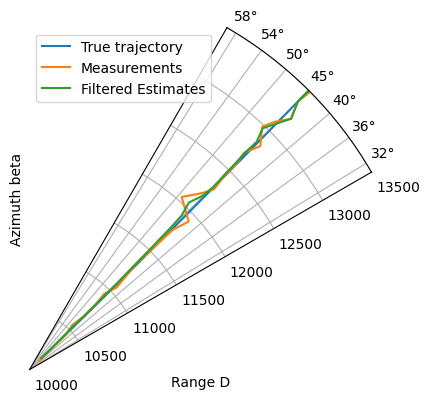

In [74]:
beta_true = X_vector_p[1, :]
D_true = X_vector_p[0, :]

beta_meas = Z_p[1, :]
D_meas = Z_p[0, :]

beta_filt = X_filtered_p[1, :]
D_filt = X_filtered_p[0, :]

plt.figure(figsize= (15,5))
plt.subplot(131,projection = 'polar')
plt.polar(beta_true, D_true, label = 'True trajectory')
plt.polar(beta_meas, D_meas, label = 'Measurements')
plt.polar(beta_filt, D_filt,  label = 'Filtered Estimates')
plt.ylim([10000,13500])
plt.xlim([np.pi/6,np.pi/3])
plt.grid()
plt.xlabel('Range D')
plt.ylabel('Azimuth beta')
plt.grid()
plt.legend()

plt.show()

### Errors of extrapolation and filtration estimates of range D and azimuth $\beta$

In [47]:
def final_error(sample_size: int = 26, M: int = 500, X0: float = 13500/np.sqrt(2), V0_x: float = -50, Y0: float = 13500/np.sqrt(2), V0_y: float = -45, meas_variance_D: float = 20**2, meas_variance_beta: float = 0.02**2, P0_0_diag: float = 10**10):
    #Initialization of matrices
    Error_true_filtered_p = np.zeros((2, sample_size))
    Error_true_extrapol_p = np.zeros((2, sample_size))

    for i in range(M):
        # State vector
        X_vector_c, X_vector_p = state_equation(sample_size=sample_size, X0=X0, V0_x=V0_x, Y0=Y0, V0_y=V0_y, T=2)
        # Measurements
        Z_p, Z_c_pseudo_vector, R_cov = measurement_equation(X_p=X_vector_p, meas_variance_D=meas_variance_D, meas_variance_beta=meas_variance_beta)
        # Kalman filter
        X_filtered_p, X_extrapol_p, K_gain_P = Kalman_filter(Z=Z_c_pseudo_vector, R=R_cov, sample_size=sample_size, X0=40000, V0_x=-20, Y0=40000, V0_y=-20, T=2, P0_0_diag=P0_0_diag)
        # Error calculation
        Error_true_filtered_p += (X_vector_p - X_filtered_p) ** 2
        Error_true_extrapol_p += (X_vector_p - X_extrapol_p) ** 2

    #Final error calculation over M runs
    RMSE_true_filtered_p = np.sqrt(Error_true_filtered_p / (M - 1))
    RMSE_true_extrapol_p = np.sqrt(Error_true_extrapol_p / (M - 1))

    return RMSE_true_filtered_p, RMSE_true_extrapol_p

In [119]:
RMSE_true_filtered_p, RMSE_true_extrapol_p = final_error(sample_size=26, M=500, X0=13500/np.sqrt(2), V0_x=-50, Y0=13500/np.sqrt(2), V0_y=-45, meas_variance_D = 20**2, meas_variance_beta = 0.02**2, P0_0_diag=10**10)

### Figure 3. Errors of extrapolation and filtration estimates of range D and azimuth $\beta$

In [121]:
fig = go.Figure()

sample_size = 26
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered_p[0, 3:]
y_RMSE_true_extrapol = RMSE_true_extrapol_p[0, 3:]
y_sigma_d = np.ones(sample_size-3) * 20

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, name = 'RMSE of filtered estimates', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_extrapol, name = 'RMSE of extrapolated estimates', 
                         line_color = colors[6]))

fig.add_trace(go.Scatter(x = x, y = y_sigma_d, name = 'Std \u03c3<sub>D</sub>', 
                         line_color = colors[5]))

fig.update_layout(template = 'simple_white', 
                  title = 'True errors of estimation',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  #xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

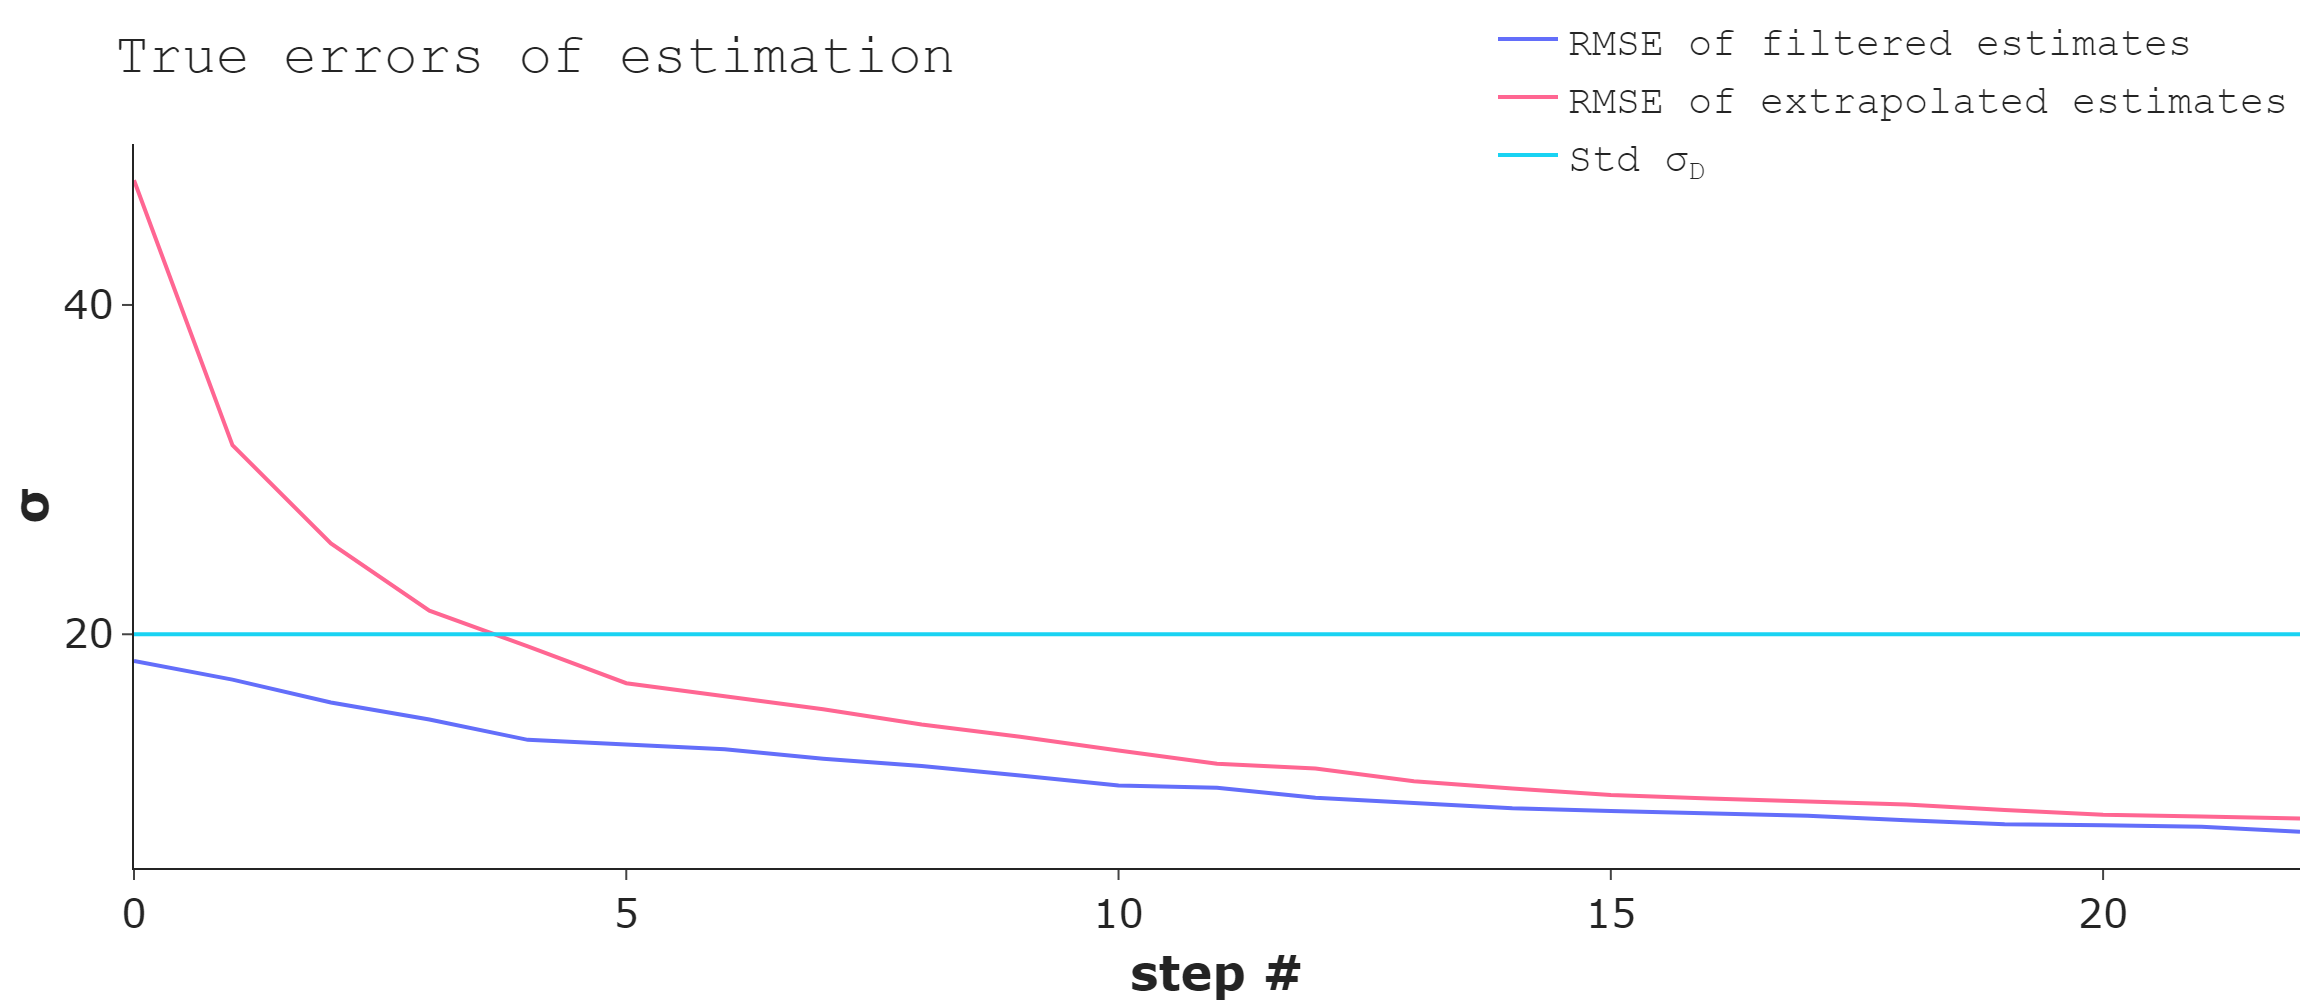

In [122]:
fig.write_image(f"True errors of estimation.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"True errors of estimation.png")

In [123]:
fig = go.Figure()

sample_size = 26
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered_p[1, 3:]
y_RMSE_true_extrapol = RMSE_true_extrapol_p[1, 3:]
y_sigma_beta = np.ones(sample_size-3) * 0.02

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, name = 'RMSE of filtered estimates', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_extrapol, name = 'RMSE of extrapolated estimates', 
                         line_color = colors[6]))

fig.add_trace(go.Scatter(x = x, y = y_sigma_beta, name = 'Std \u03c3<sub>\u03B2</sub>', 
                         line_color = colors[5]))

fig.update_layout(template = 'simple_white', 
                  title = 'True estimation errors',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  #xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

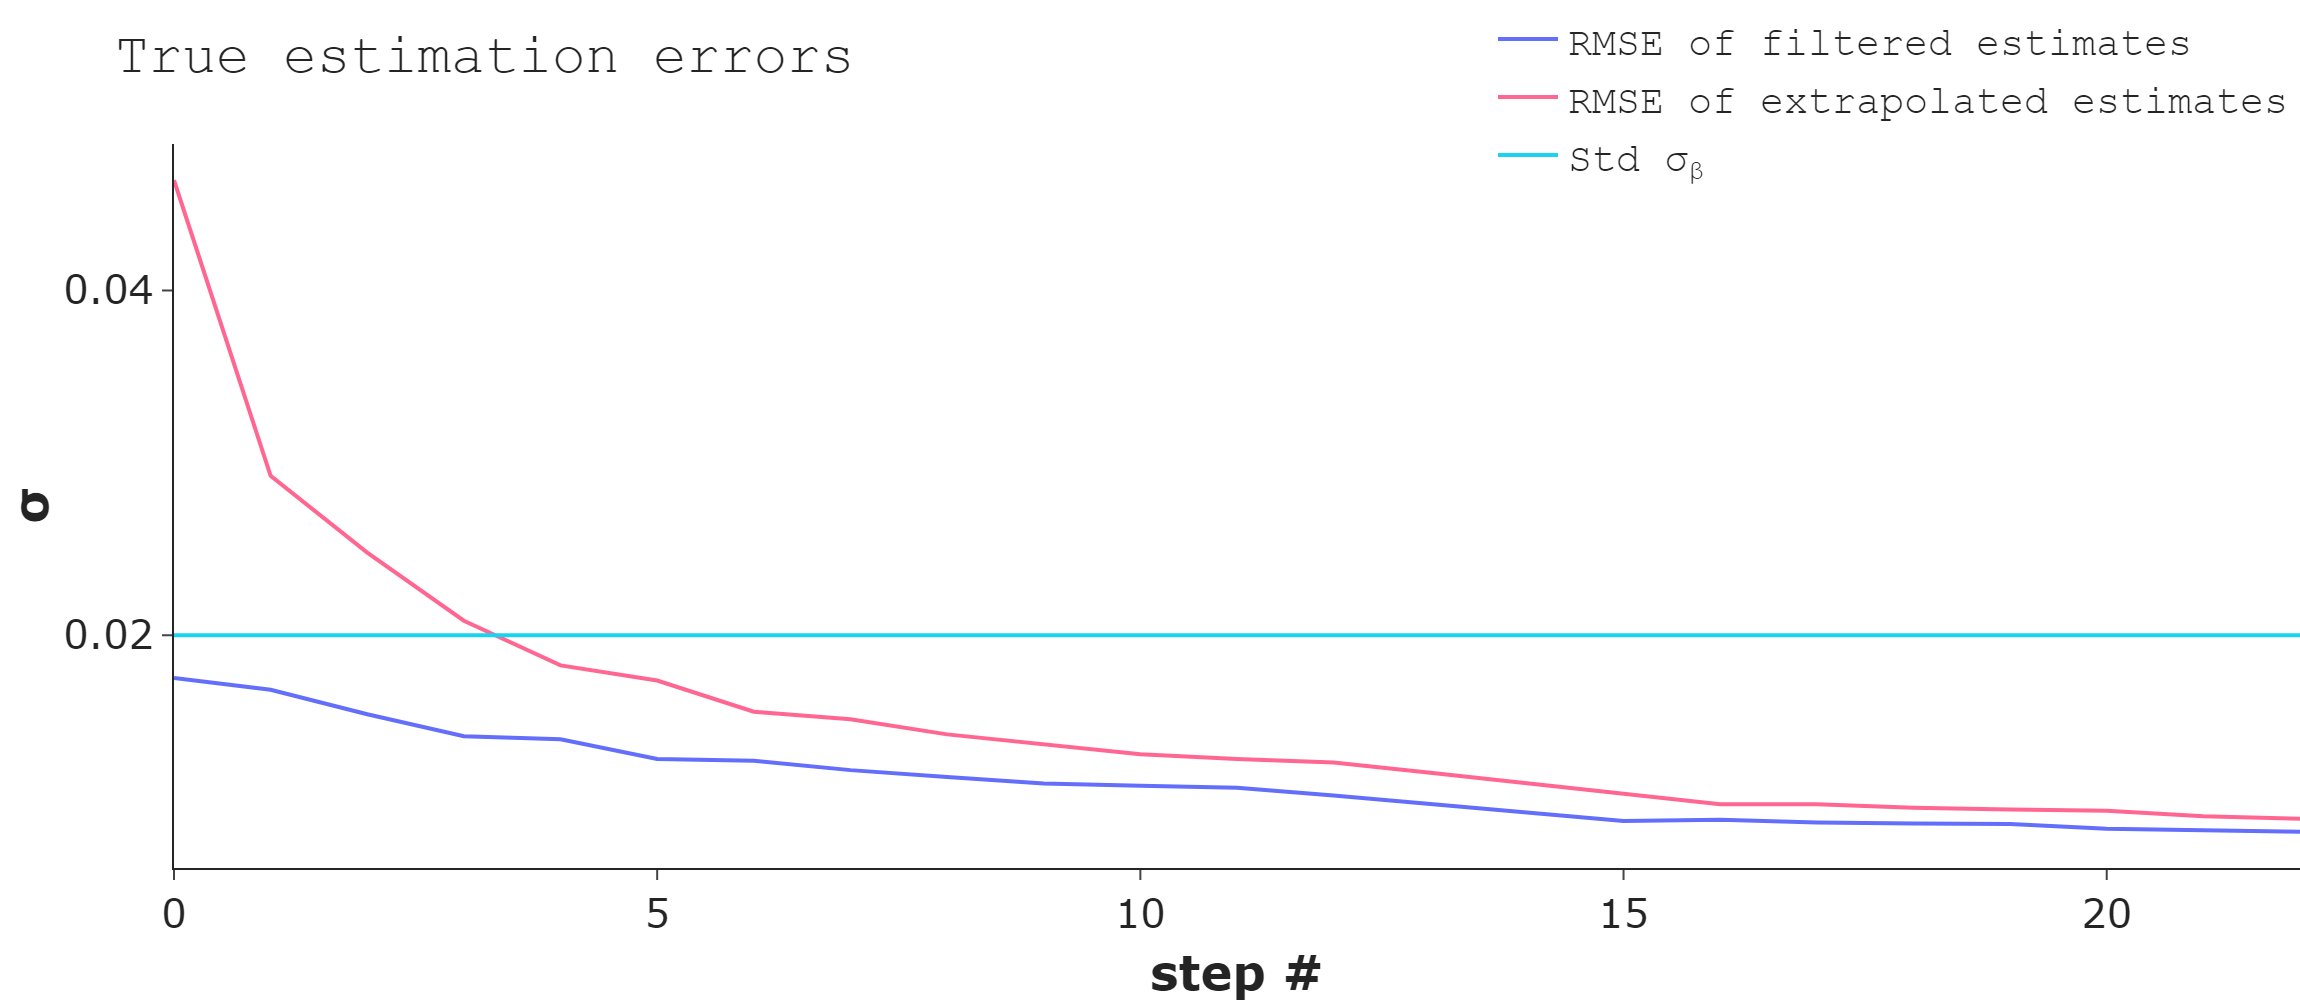

In [124]:
fig.write_image(f"True errors of estimation1.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"True errors of estimation1.png")

Errors of extrapolation and filtration estimates decrease with time and become lower than noise after 7 steps.

### Figure 4. Dependence of coordinate x on azimuth $\beta$

In [152]:
fig = go.Figure()

sample_size = 26
beta = X_vector_p[1, 1:sample_size]
D = X_vector_p[0, 1:sample_size]
x = D * np.sin(beta)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = beta, y = x, name = '', mode = 'markers',
                         marker_color = colors[0]))

fig.update_layout(template = 'simple_white', 
                  title = 'Dependence of coordinate on azimuth',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>azimuth \u03B2</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  width = 1150, height = 500)
fig.show()

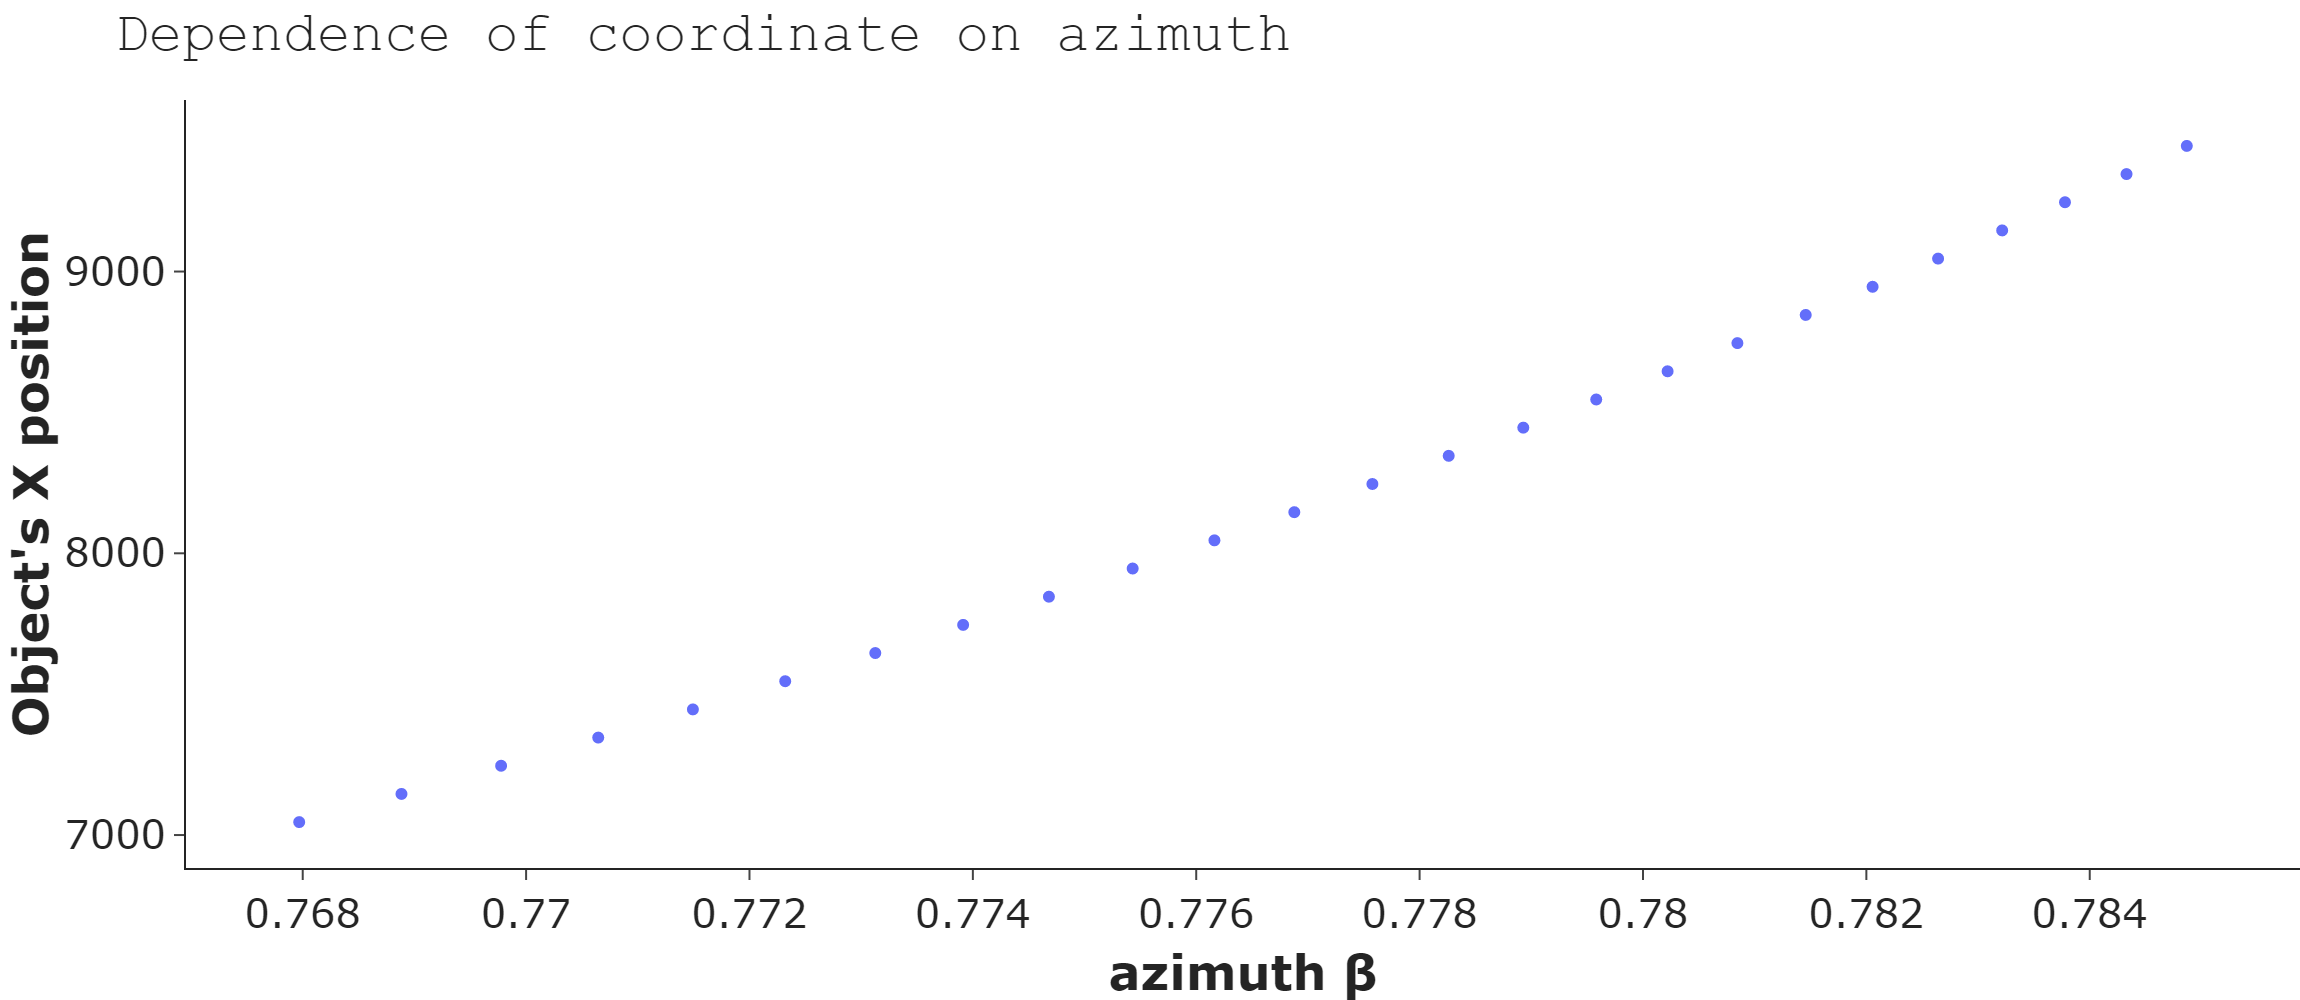

In [153]:
fig.write_image(f"Dependence of coordinate on azimuth.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"Dependence of coordinate on azimuth.png")

Dependence of coordinate x on azimuth $\beta$ is close to linear ($R^2$ = 0.995), which means that linearization errors are insignificant.

### Calculate condition number of covariance matrix R

In [127]:
def condition_number(R: np.array):
    eigenvalues = np.zeros((2, R.shape[0]))
    con_num = np.zeros(R.shape[0])
    for i in range(0, R.shape[0]):
        eigenvalues[:, i], eigenvectors = np.linalg.eig(R[i, :, :])
    
        if eigenvalues[0, i] > eigenvalues[1, i]:
            con_num[i] = eigenvalues[0, i] / eigenvalues[1, i]
        else:
            con_num[i] = eigenvalues[1, i] / eigenvalues[0, i]
    return con_num

### Figure 5. Condition number analysis over the whole observation interval

In [129]:
fig = go.Figure()

sample_size = 26
x = np.arange(sample_size)
y_con_num = condition_number(R=R_cov)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_con_num, name = 'Condition number', 
                         line_color = colors[0]))

fig.update_layout(template = 'simple_white', 
                  title = 'Condition number of covariance matrix R <br>  over the observation interval',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  width = 1150, height = 500)
fig.show()

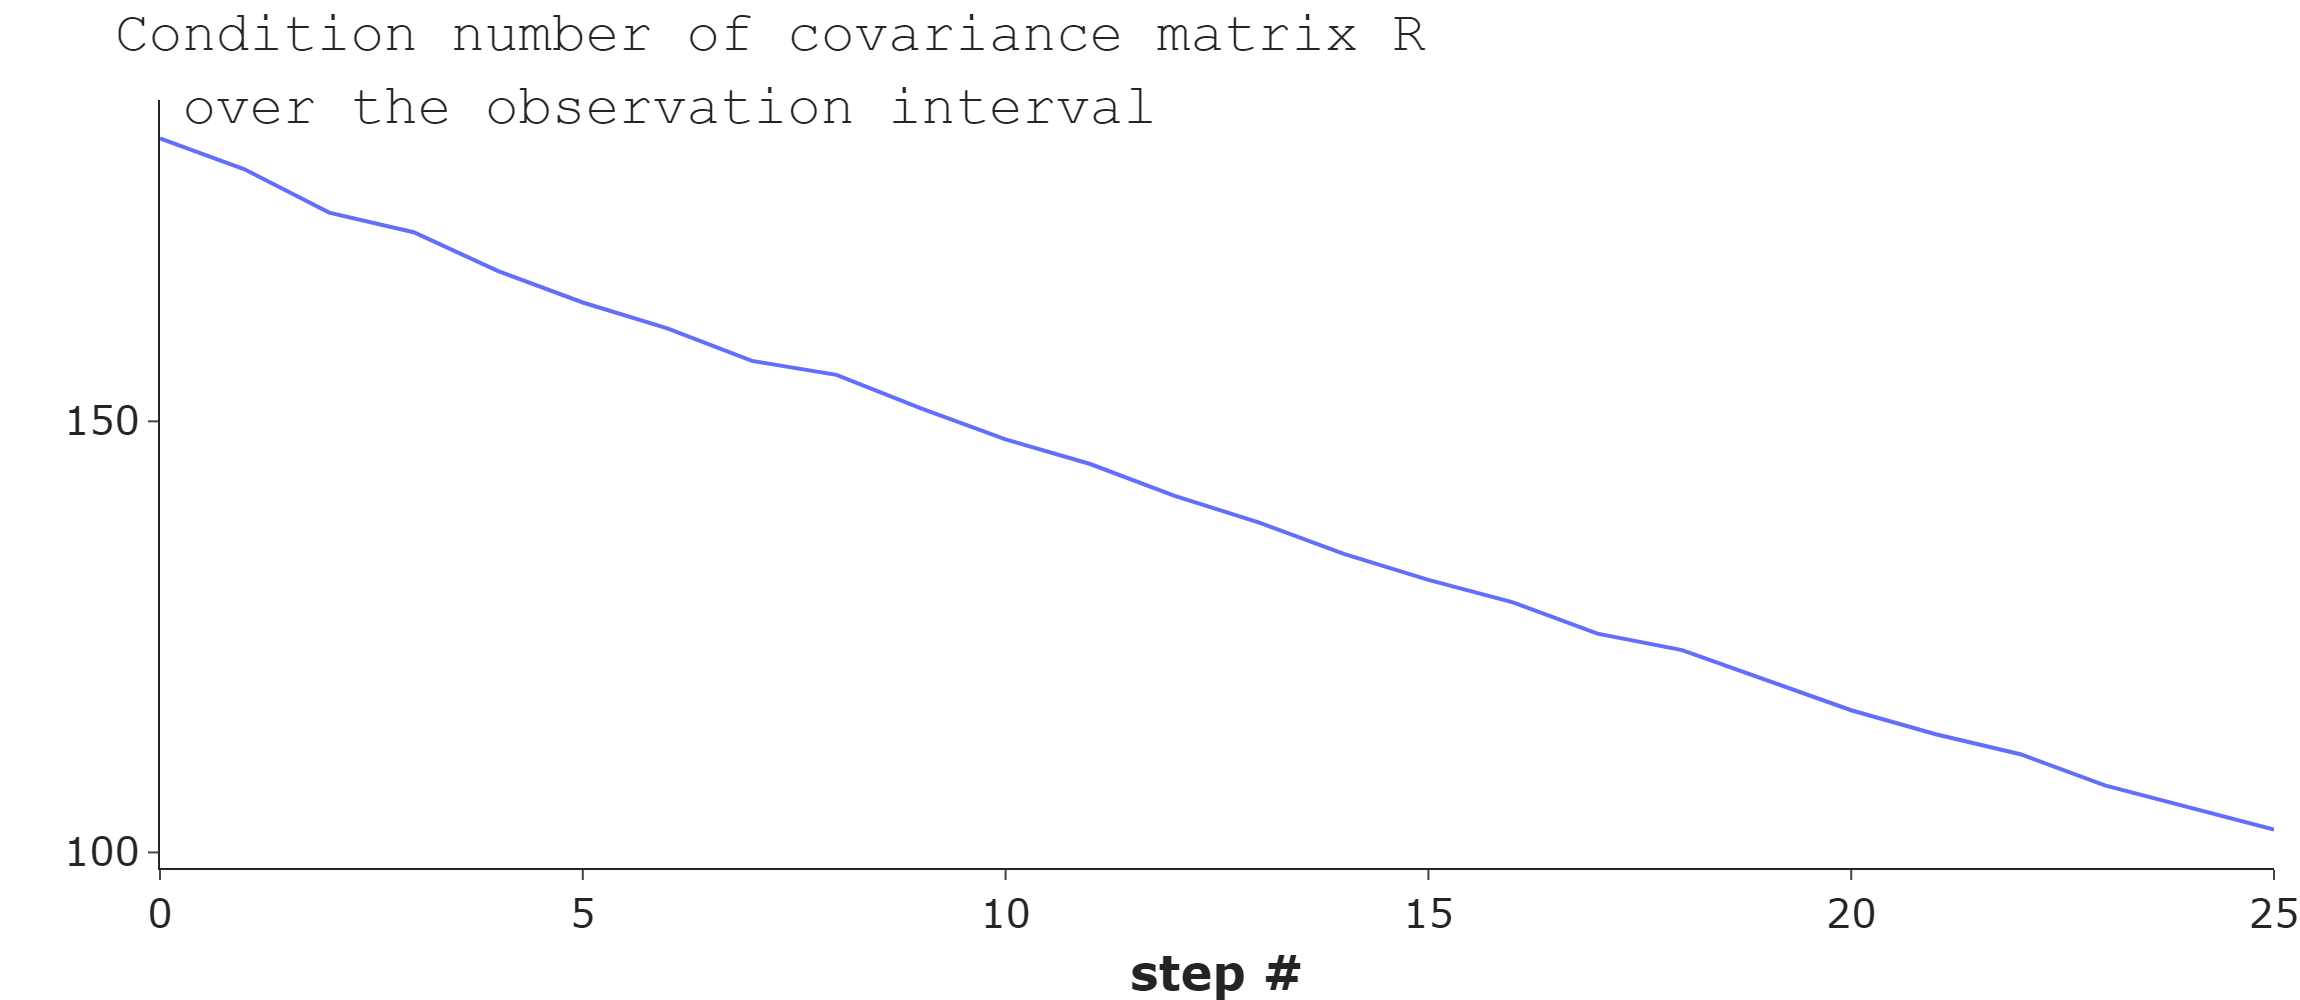

In [130]:
fig.write_image(f"Condition number of covariance matrix R.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"Condition number of covariance matrix R.png")

Although condition number is decreasing with each subsequent step, the first 80 or so points the condition number is > 10 and after 100 steps it becomes very close to 1 (1.1-1.5). Hence, for the 26 steps problem would be "poorly" conditioned with condition number equal to approx. 140. 

### Figure 6. Analysis of filter gain K

In [134]:
fig = go.Figure()

sample_size = 26
x = np.arange(sample_size)
y_K_gain_p = K_gain_P[:sample_size, 0, 0]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_K_gain_p, name = 'Condition number', 
                         line_color = colors[0]))

fig.update_layout(template = 'simple_white', 
                  title = 'Filter gain dynamics',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  width = 1150, height = 500)
fig.show()

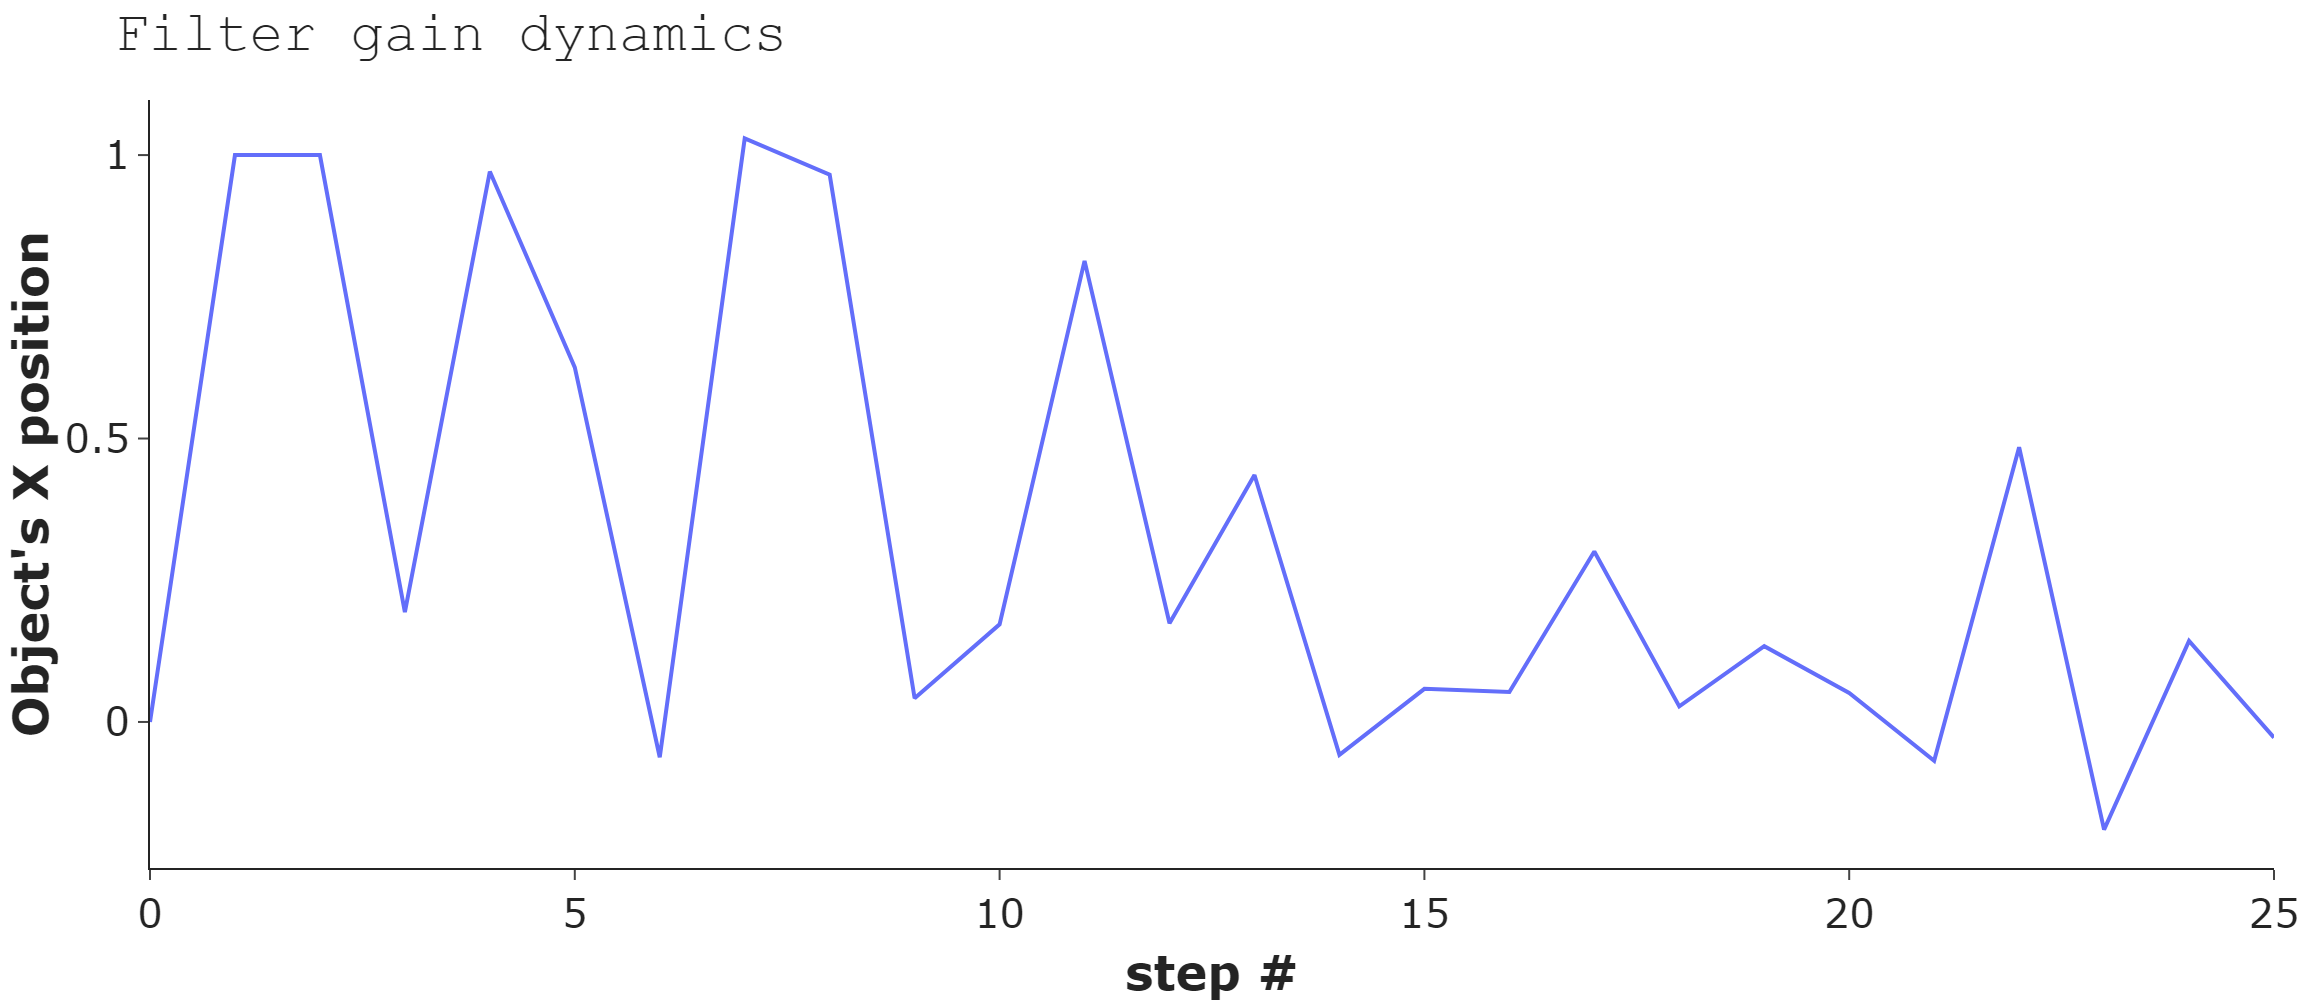

In [135]:
fig.write_image(f"Filter gain dynamics.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"Filter gain dynamics.png")

We observe damped oscillations of filter gain, since Kalman filter has an embedded analytical model of object's movement and after certain number of steps follows the model rather than real measurements as discussed during the lectures. That's why we observe filter gain close to zero after several dozens of steps 

### Generate motion at a close distance from an observer

In [136]:
X_vector_c_close_dist, X_vector_p_close_dist = state_equation(sample_size=26, X0=(3500/np.sqrt(2)), V0_x=-50, Y0=(3500/np.sqrt(2)), V0_y=-45, T=2)
Z_p_close_dist, Z_c_pseudo_vector_close_dist, R_cov_close_dist = measurement_equation(X_p=X_vector_p_close_dist, meas_variance_D=20**2, meas_variance_beta=0.02**2)
X_filtered_p_close_dist, X_extrapol_p_close_dist, K_gain_P_close_dist = Kalman_filter(Z=Z_c_pseudo_vector_close_dist, R=R_cov_close_dist, sample_size=26, X0=40000, V0_x=-20, Y0=40000, V0_y=-20, T=2, P0_0_diag=10**10)
RMSE_true_filtered_p_close_dist, RMSE_true_extrapol_p_close_dist = final_error(sample_size=26, M=500, X0=(3500/np.sqrt(2)), V0_x=-50, Y0=(3500/np.sqrt(2)), V0_y=-45, meas_variance_D = 20**2, meas_variance_beta = 0.02**2, P0_0_diag=10**10)

### Figure 7. Filtration estimates in Polar coordinates at a close distance from an observer

In [138]:
fig = go.Figure()

sample_size = 26
beta = X_filtered_p_close_dist[1, :]
D = X_filtered_p_close_dist[0, :]

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatterpolar(r = D, theta = beta, name = '', 
                         line_color = colors[0]))

fig.update_layout(template = 'simple_white', 
                  title = 'Filtered estimates in Polar <br>coordinates',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  #xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
                  
fig.show()

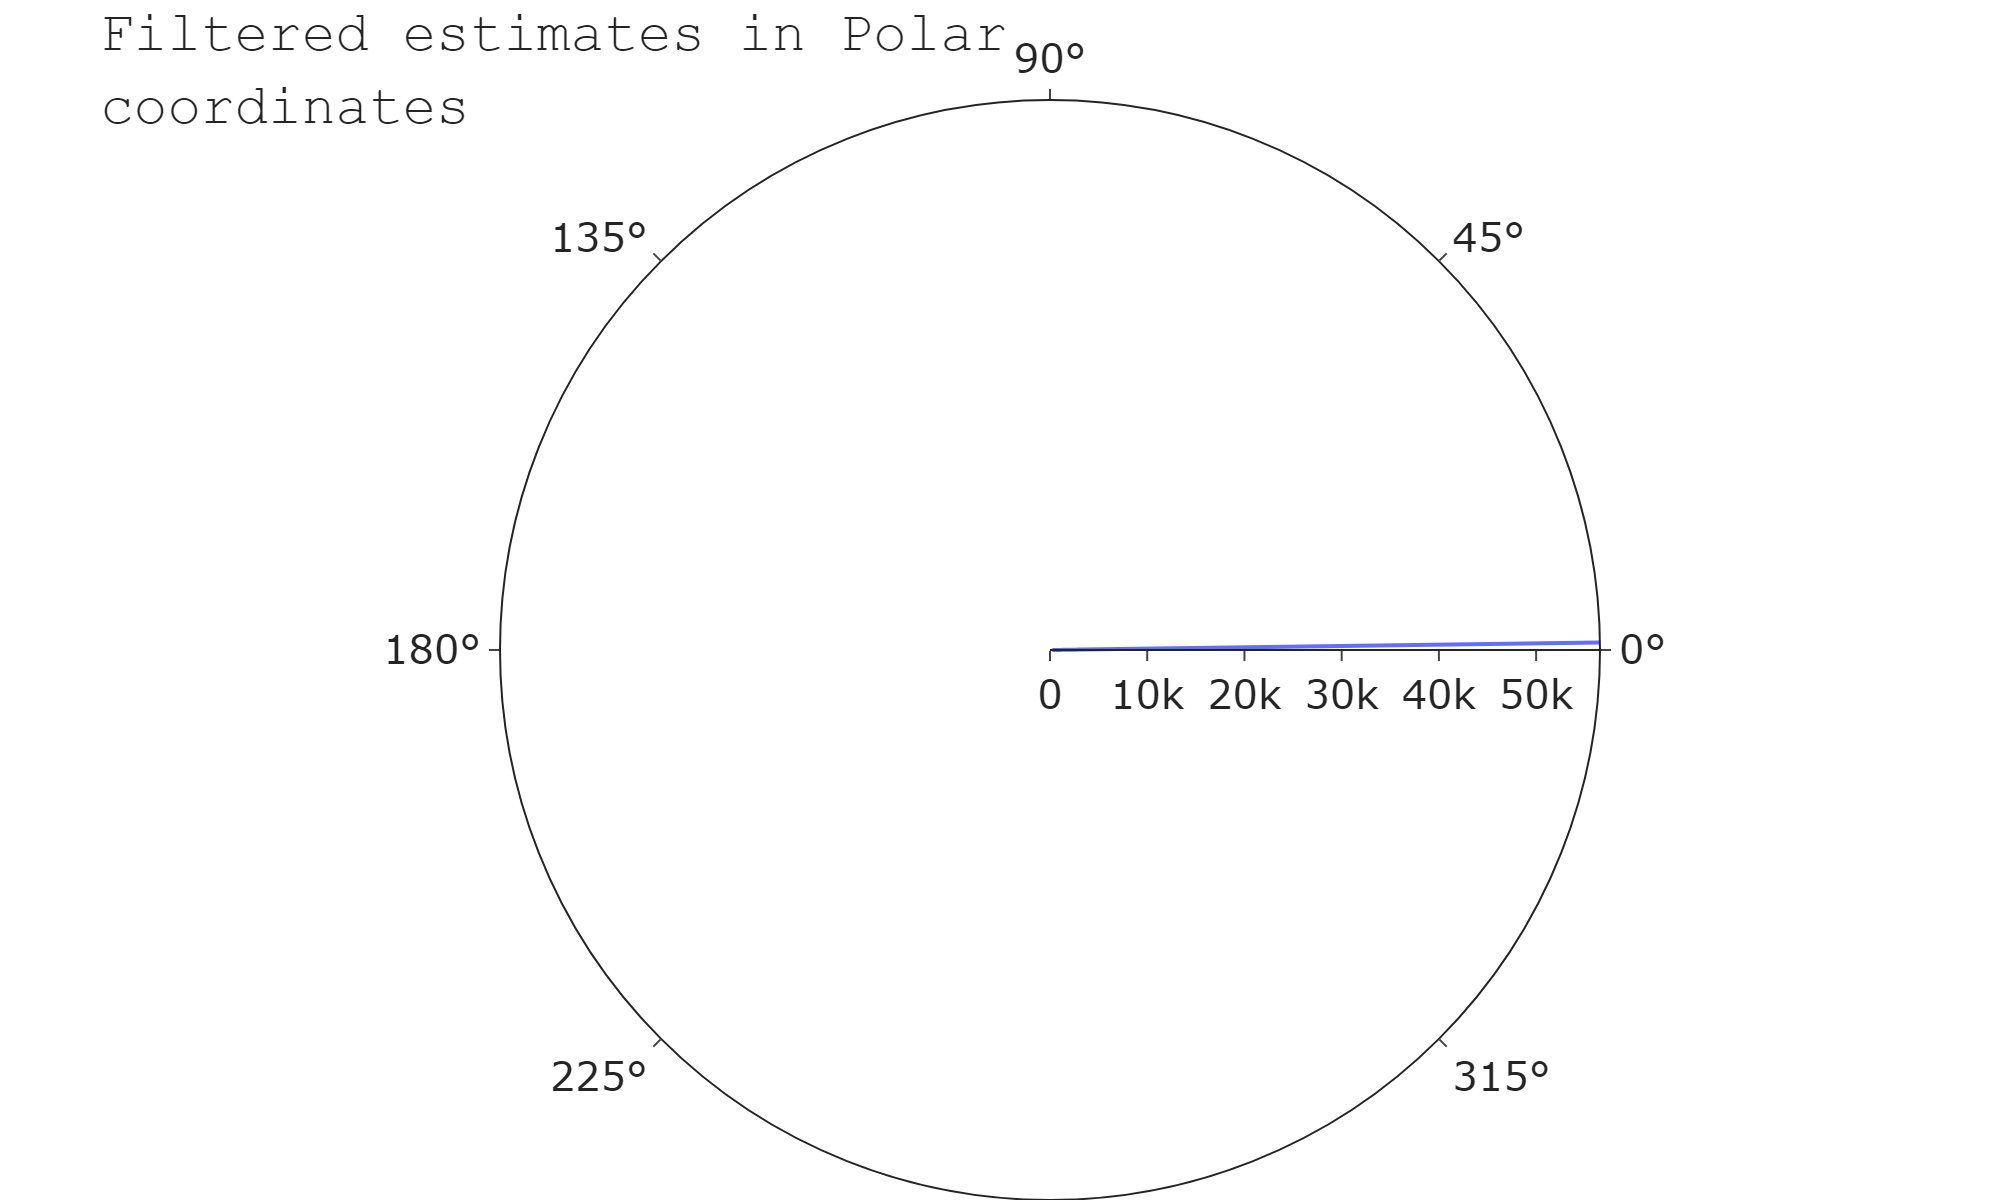

In [139]:
fig.write_image(f"Filtered estimates in Polar coordinates.png", 
                format = 'png', width = 1000, height = 600, scale = 2)
Image(f"Filtered estimates in Polar coordinates.png")

### Figure 8. True error of filtered and extrapolated estimates with a motion at close distance from an observer

In [141]:
fig = go.Figure()

sample_size = 26
x = np.arange(sample_size)
y_RMSE_true_filtered_p_close_dist = RMSE_true_filtered_p_close_dist[0, 3:]
y_RMSE_true_extrapol_p_close_dist = RMSE_true_extrapol_p_close_dist[0, 3:]
y_sigma_d = np.ones(sample_size-3) * 20

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered_p_close_dist, name = 'RMSE of filtered estimates', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_extrapol_p_close_dist, name = 'RMSE of extrapolated estimates', 
                         line_color = colors[6]))

fig.add_trace(go.Scatter(x = x, y = y_sigma_d, name = 'Std \u03c3<sub>D</sub>', 
                         line_color = colors[5]))

fig.update_layout(template = 'simple_white', 
                  title = 'True errors of estimation with a motion <br>at close distance from an observer',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  #xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

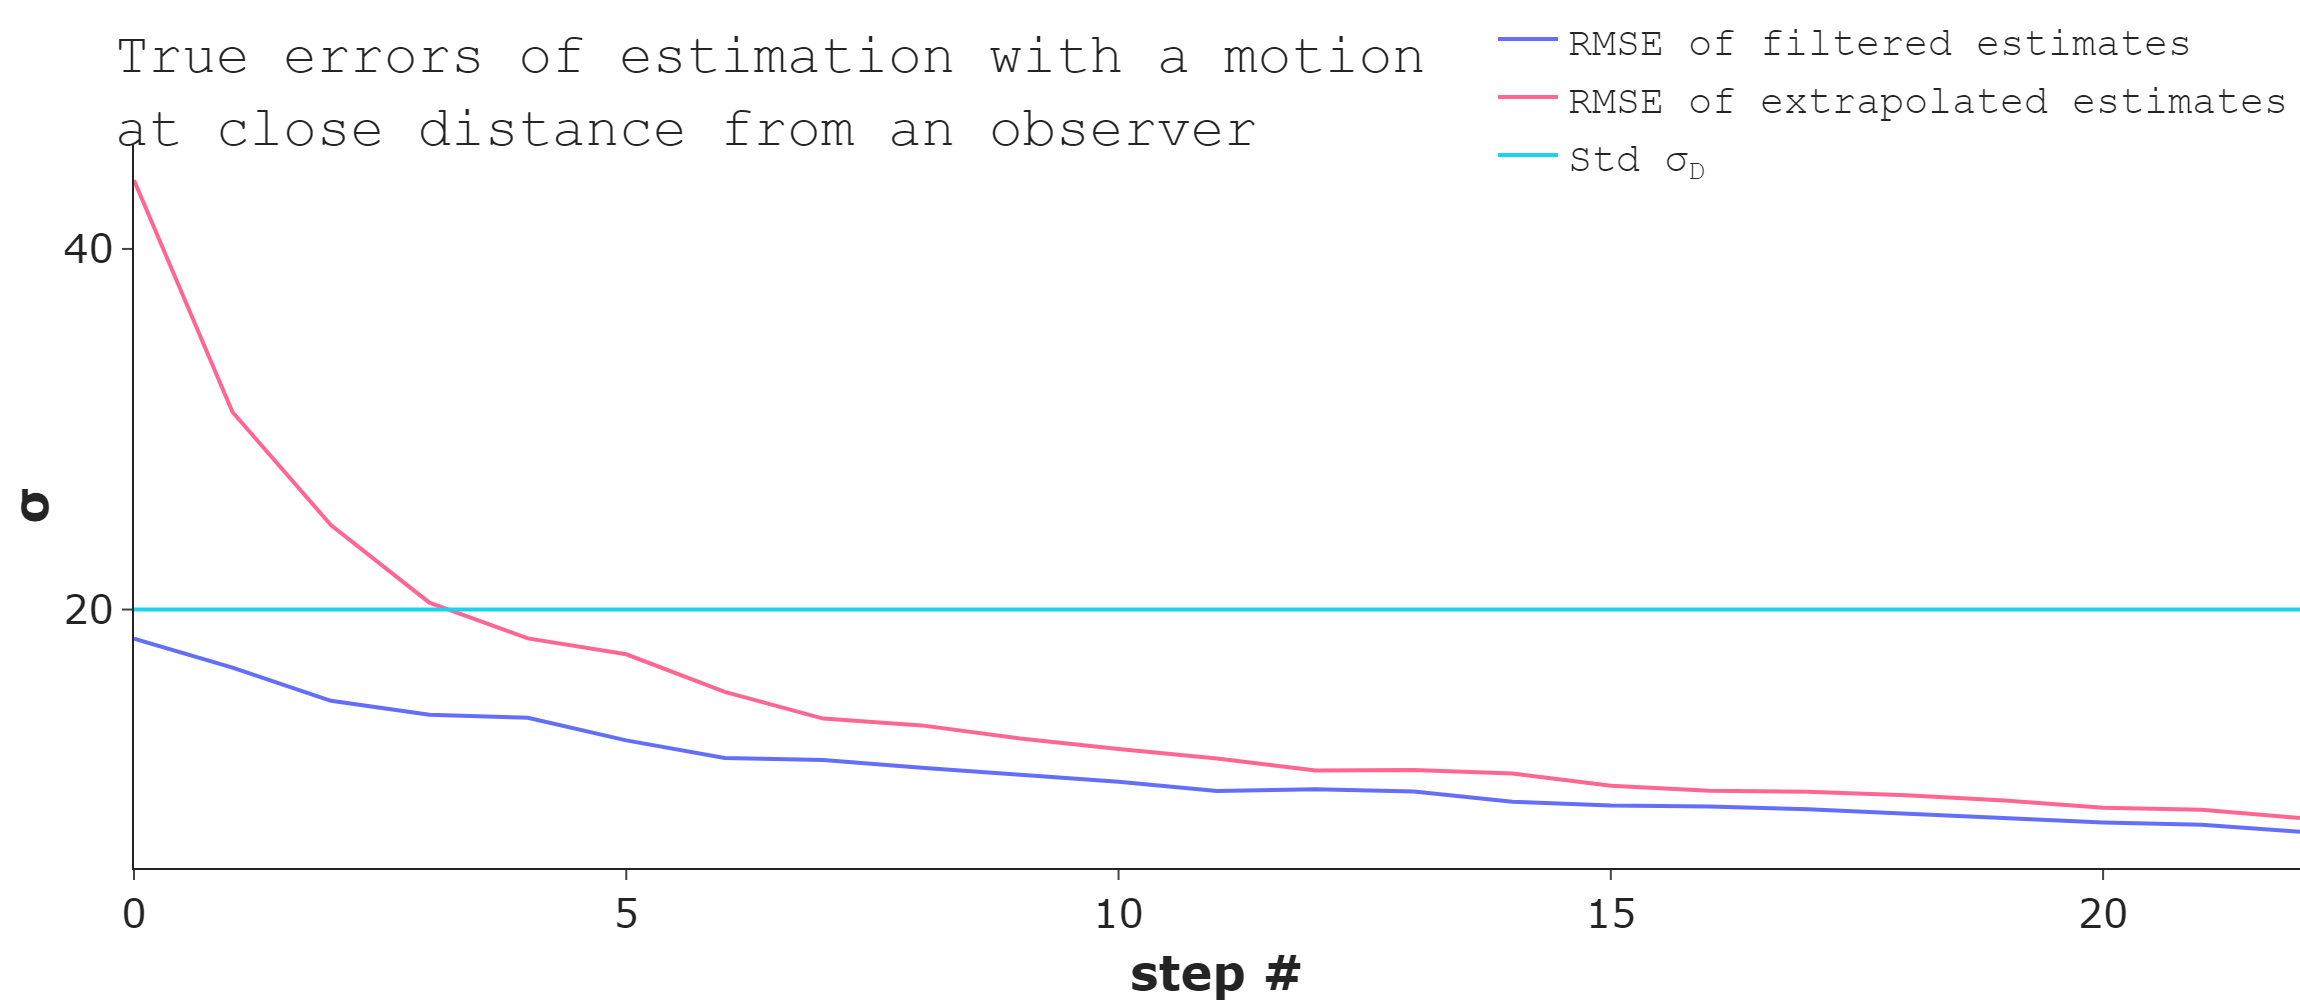

In [142]:
fig.write_image(f"True errors of estimation with a motion at close distance to a observer.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"True errors of estimation with a motion at close distance to a observer.png")

In [144]:
fig = go.Figure()

sample_size = 26
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered_p_close_dist[1, 3:]
y_RMSE_true_extrapol = RMSE_true_extrapol_p_close_dist[1, 3:]
y_sigma_beta = np.ones(sample_size-3) * 0.02

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, name = 'RMSE of filtered estimates', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_extrapol, name = 'RMSE of extrapolated estimates', 
                         line_color = colors[6]))

fig.add_trace(go.Scatter(x = x, y = y_sigma_beta, name = 'Std \u03c3<sub>\u03B2</sub>', 
                         line_color = colors[5]))

fig.update_layout(template = 'simple_white', 
                  title = 'True errors of estimation with a motion <br>at close distance from an observer',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  #xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

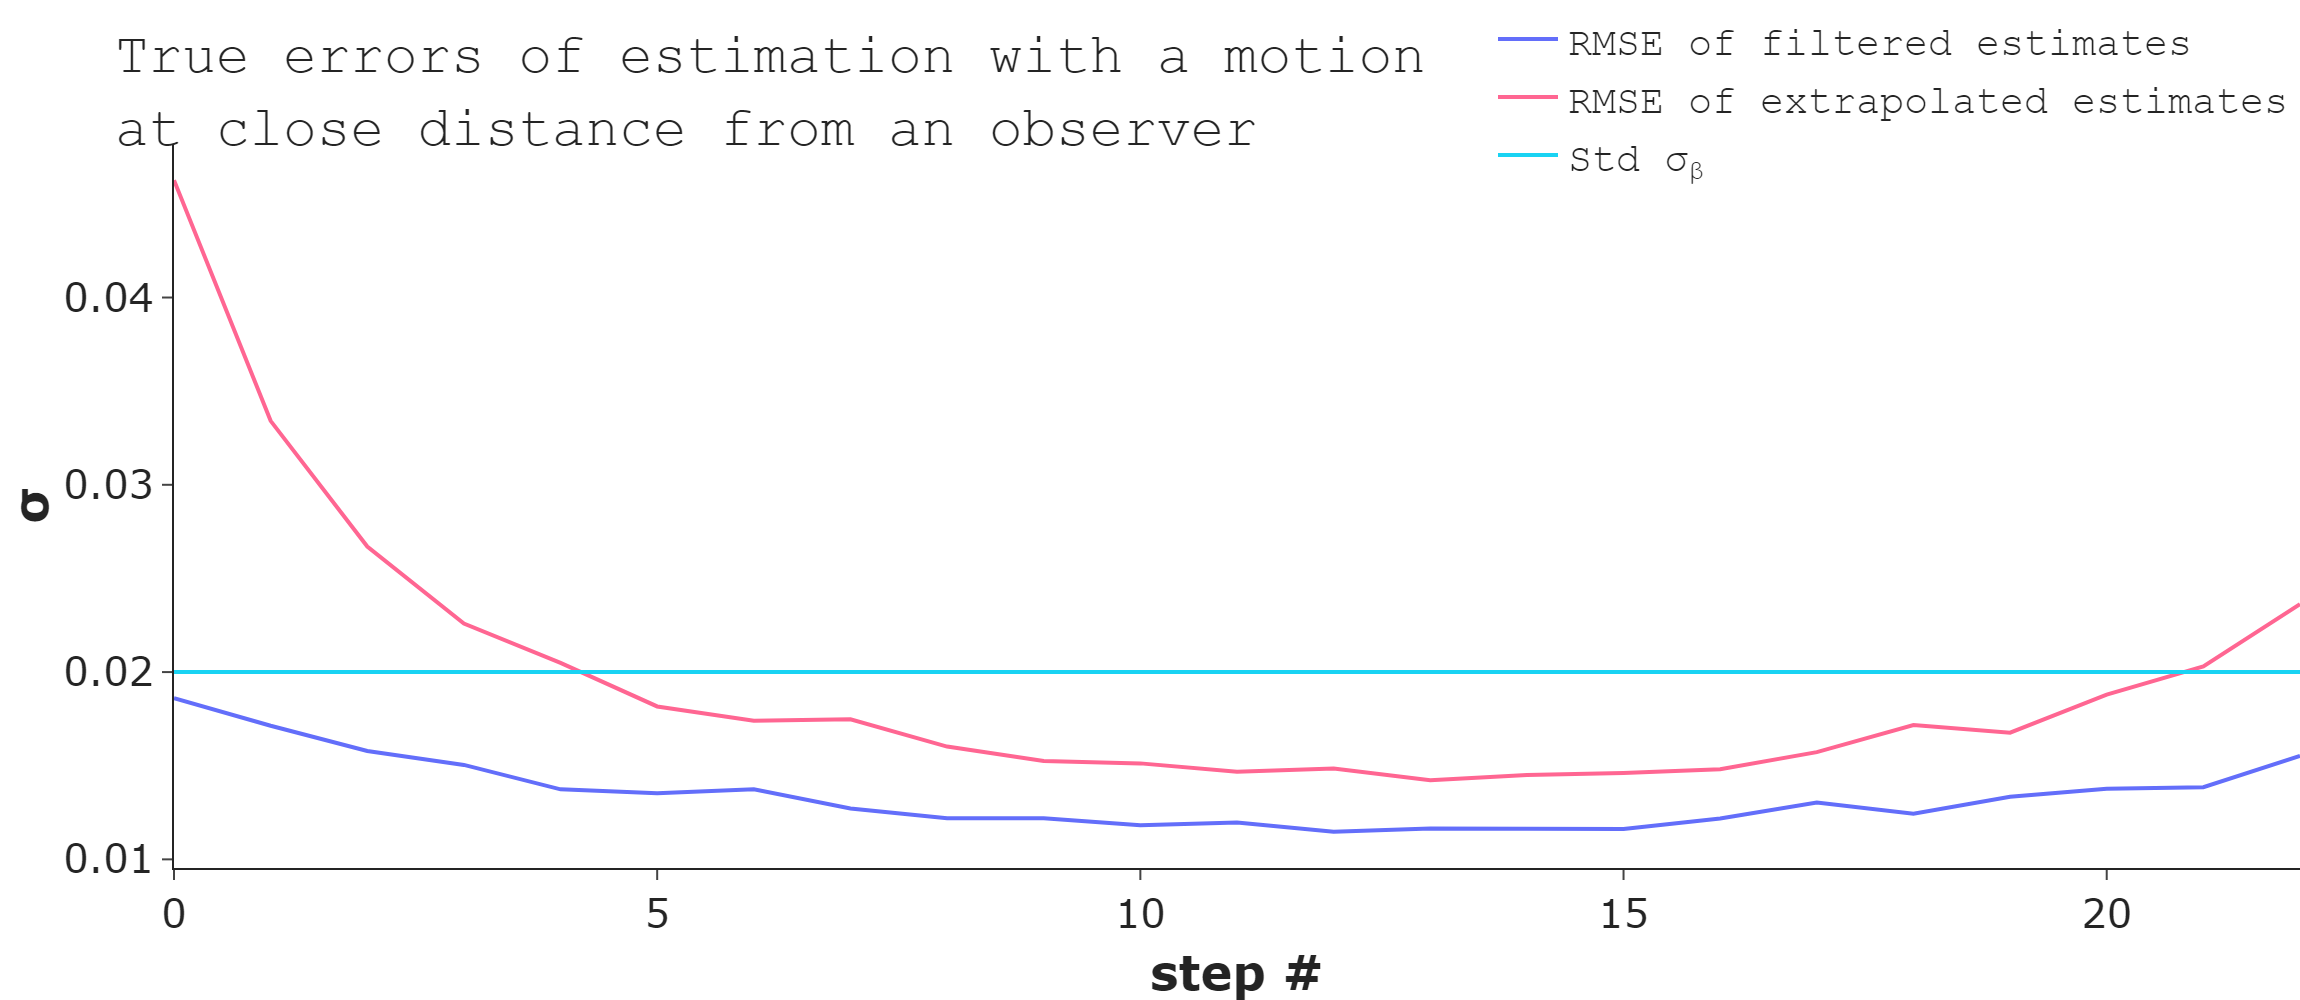

In [145]:
fig.write_image(f"True errors of estimation with a motion at close distance to a observer1.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"True errors of estimation with a motion at close distance to a observer1.png")

We increased the number of points in the trajectory from 26 to 120 points to see the bigger picture.<br>
Generally, filtration and extrapolation errors decrease asymptotycally to a certain value over time, although for the case of the object being closer to observer, azimuth filtration and extrapolation errors exceed $\sigma_{\beta}$.
Hence, when the object is close to observer and the sample size is low, filtration with Kalman filter is not effective since resulting errors exceed original measurement errors

### Figure 9. Dependence of coordinate x on azimuth $\beta$ with a motion at close distance from an observer

In [154]:
fig = go.Figure()

sample_size = 26
beta = X_vector_p_close_dist[1, :sample_size]
D = X_vector_p_close_dist[0, :sample_size]
x = D * np.sin(beta)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = beta, y = x, name = '', mode = 'markers',
                         marker_color = colors[0]))

fig.update_layout(template = 'simple_white', 
                  title = 'Dependence of coordinate on azimuth with a motion <br>   at close distance from an observer',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>azimuth \u03B2</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  width = 1150, height = 500)
fig.show()

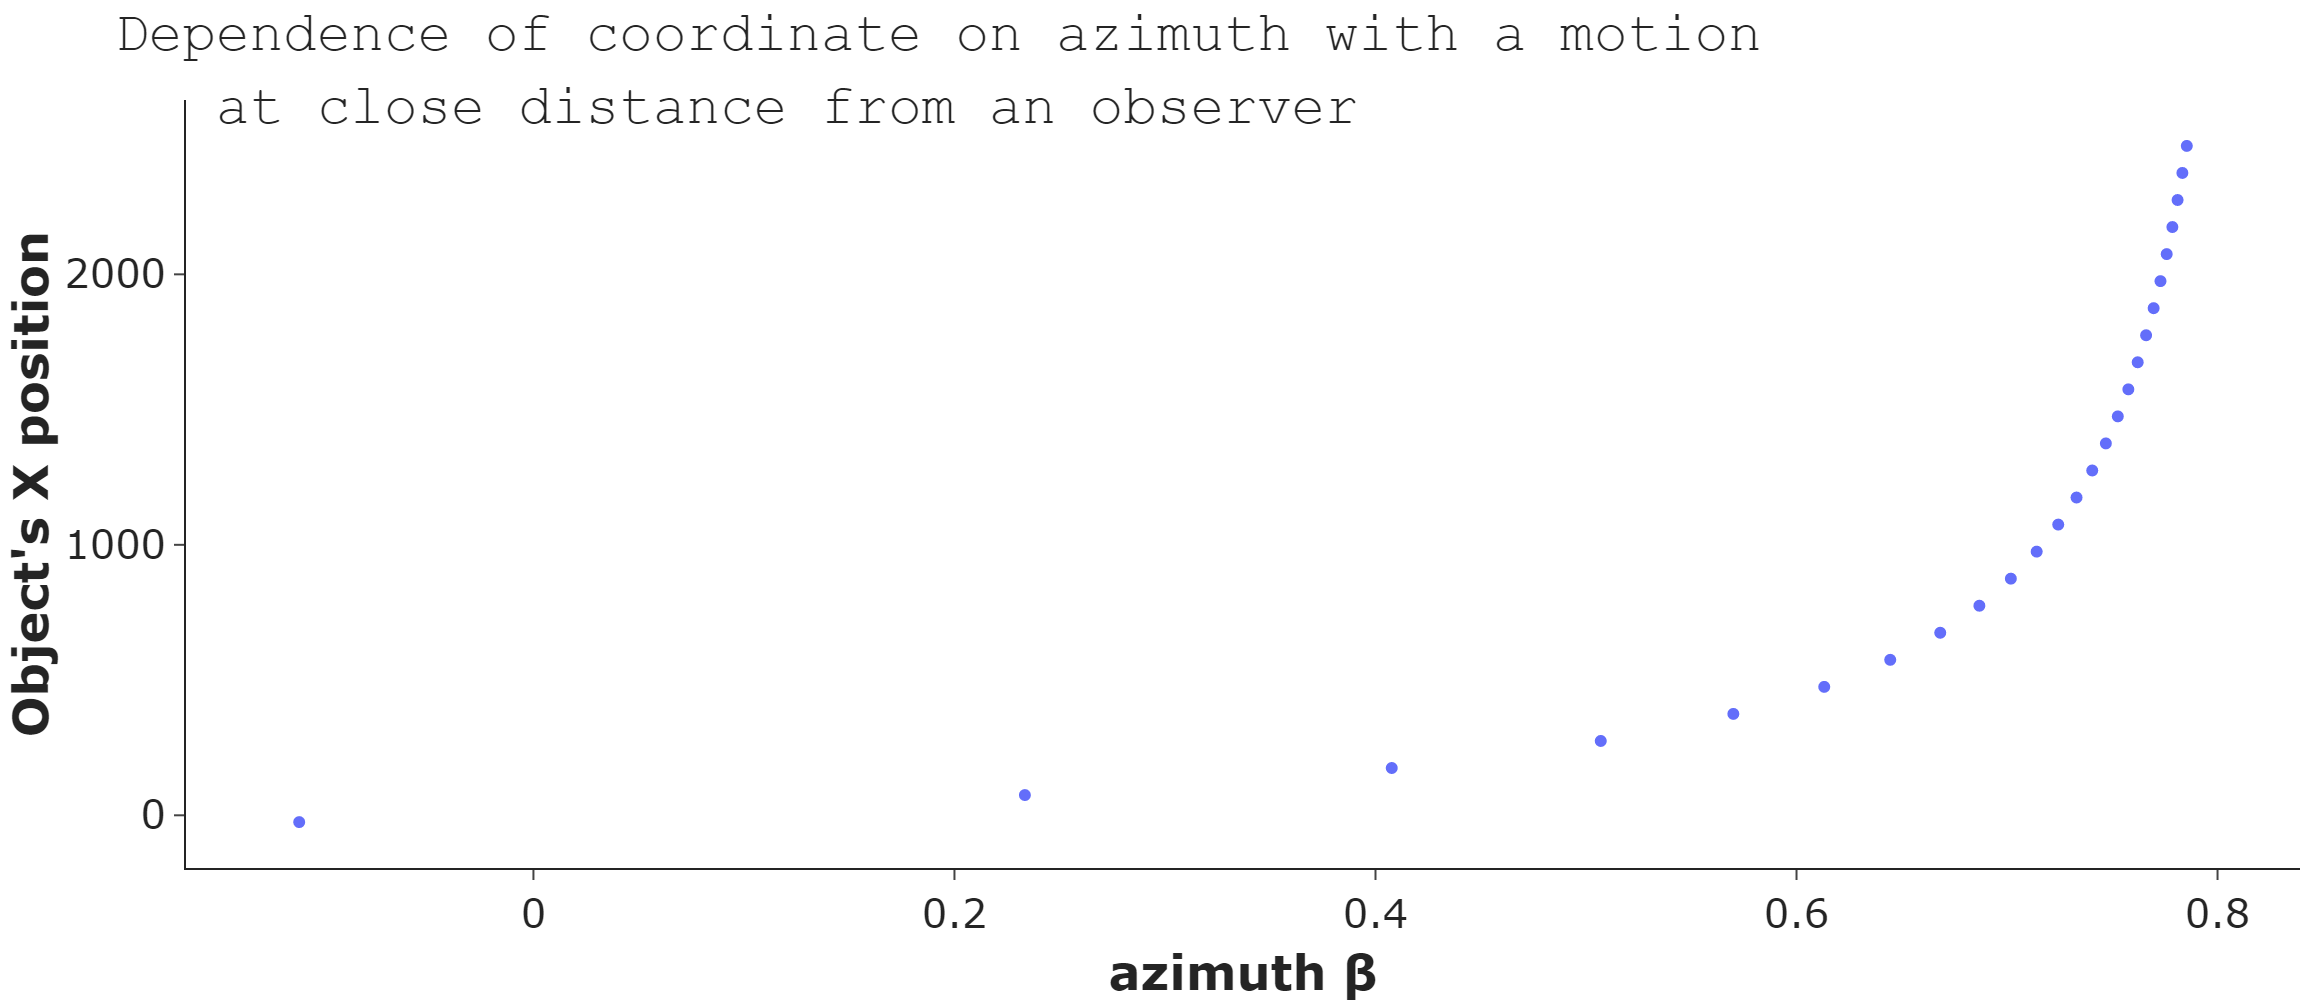

In [155]:
fig.write_image(f"Dependence of coordinate on azimuth with a motion at close distance from an observer.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"Dependence of coordinate on azimuth with a motion at close distance from an observer.png")

$X(\beta)$ dependence is nonlinear, hence the linearization error becomes significant

### Figure 10. Condition number of covariance matrix R with a motion at close distance from an observer

In [157]:
fig = go.Figure()

sample_size = 26
x = np.arange(sample_size)
y_con_num_close_dist = condition_number(R=R_cov_close_dist)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_con_num_close_dist, name = 'Condition number', 
                         line_color = colors[0]))

fig.update_layout(template = 'simple_white', 
                  title = 'Condition number of covariance matrix R with a motion <br> at close distance from an observer',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  width = 1150, height = 500)
fig.show()

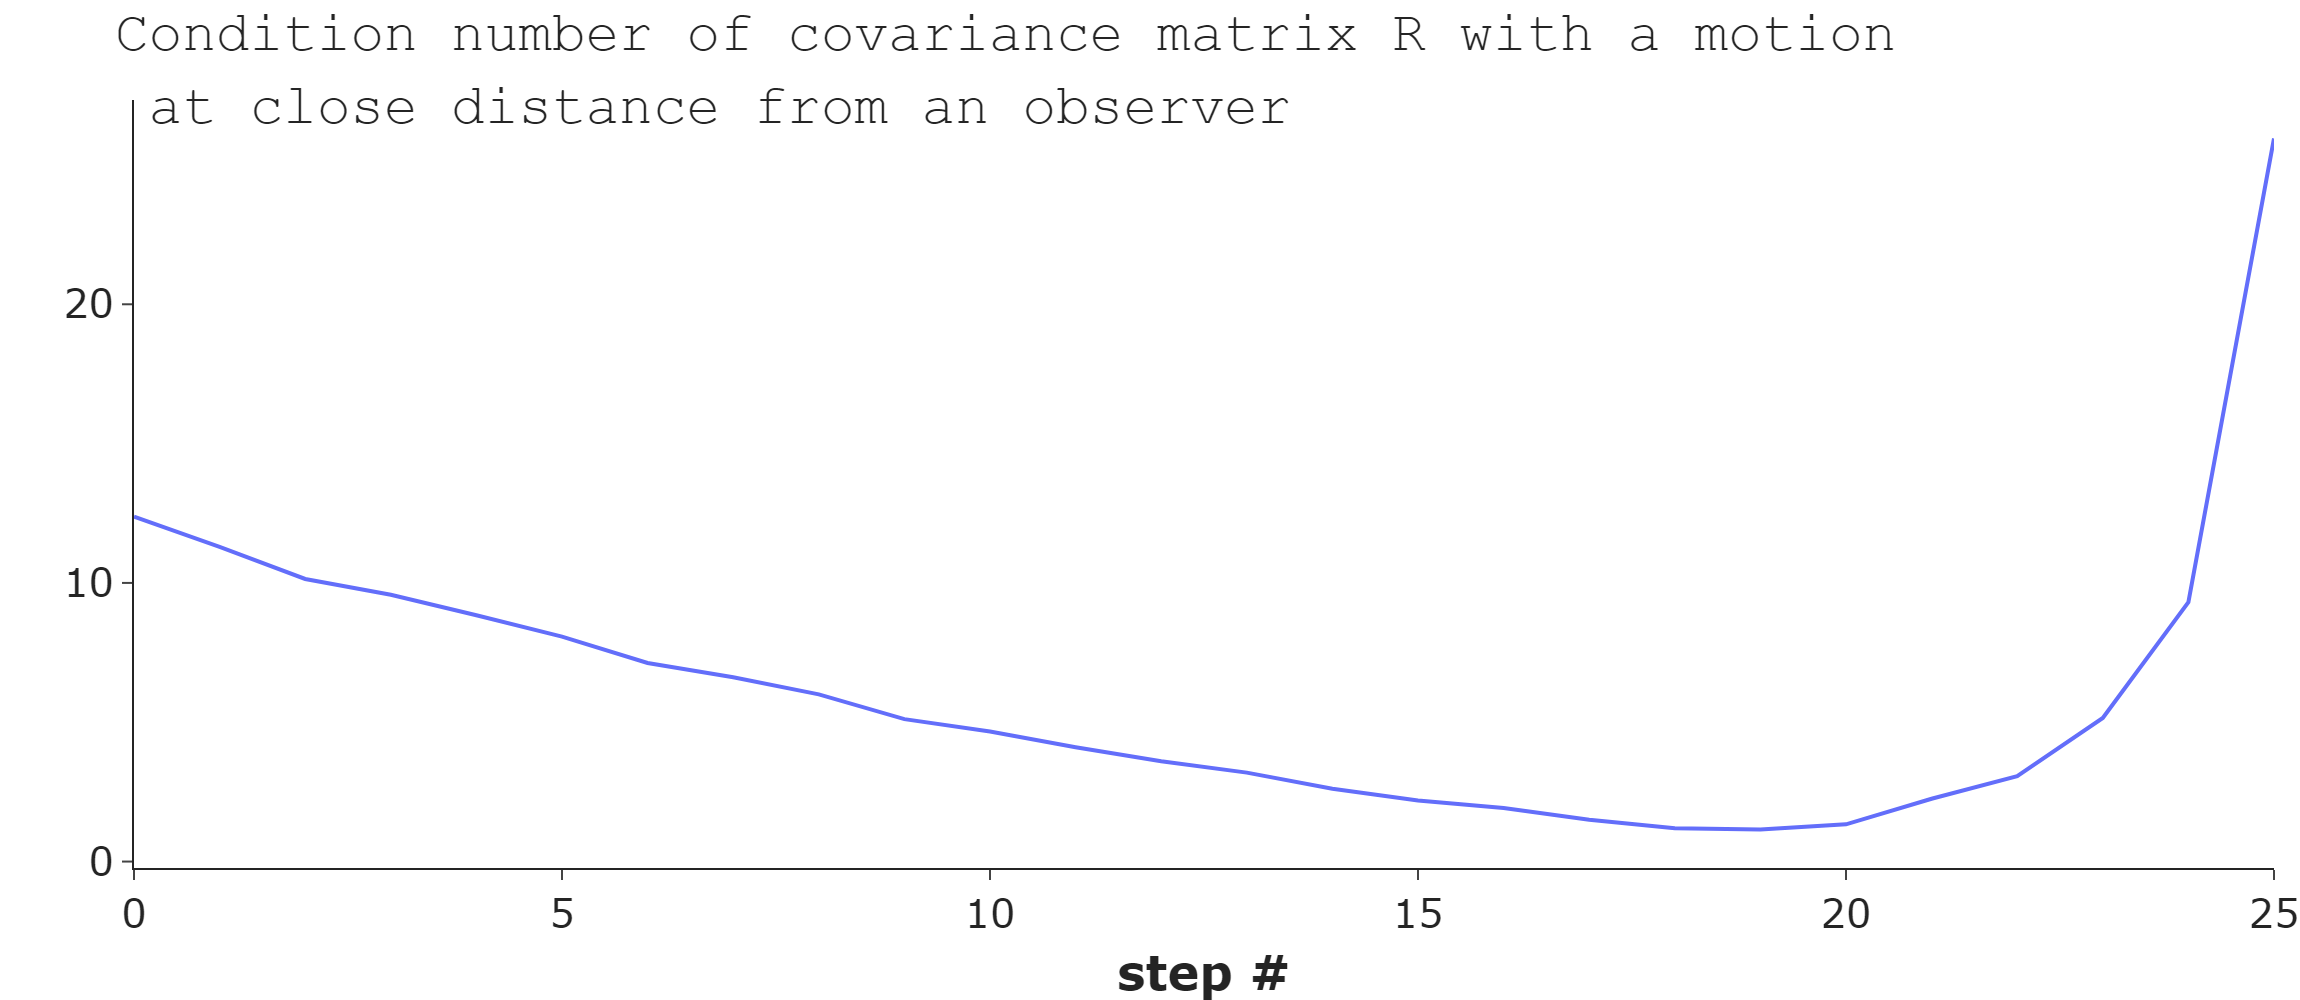

In [158]:
fig.write_image(f"Condition number of covariance matrix R with a motion at close distance from an observer.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"Condition number of covariance matrix R with a motion at close distance from an observer.png")

Condition number increases over time, although it reaches 1 near the 20th step. In case we increase the sample size to 120, condition number increases over time. This additionally illustrates the importance of linearization errors (or rather the linearity of $X(\beta)$ dependence), because the measurements follow the model only for the short period of time (approx 20 steps) if the $X(\beta)$ is non-linear, then the measurements and model diverge, hence we see an increase of condition number values.

### Generate polar measurements and apply Kalman filter with other values of variances of measurement noises

In [159]:
X_vector_c_diff_var, X_vector_p_diff_var = state_equation(sample_size=26, X0=(3500/np.sqrt(2)), V0_x=-50, Y0=(3500/np.sqrt(2)), V0_y=-45, T=2)
Z_p_diff_var, Z_c_pseudo_vector_diff_var, R_cov_diff_var = measurement_equation(X_p=X_vector_p_diff_var, meas_variance_D=50**2, meas_variance_beta=0.0015**2)
X_filtered_p_diff_var, X_extrapol_p_diff_var, K_gain_P_diff_var = Kalman_filter(Z=Z_c_pseudo_vector_diff_var, R=R_cov_diff_var, sample_size=26, X0=40000, V0_x=-20, Y0=40000, V0_y=-20, T=2, P0_0_diag=10**10)
RMSE_true_filtered_p_diff_var, RMSE_true_extrapol_p_diff_var = final_error(sample_size=26, M=500, X0=(3500/np.sqrt(2)), V0_x=-50, Y0=(3500/np.sqrt(2)), V0_y=-45, meas_variance_D=50**2, meas_variance_beta=0.0015**2, P0_0_diag=10**10)

### Figure 11. True error of filtered and extrapolated estimates with a motion at close distance from an observer and other values of variances $\sigma_{D}$ = 50 and $\sigma_{\beta}$ = 0.0015

In [160]:
fig = go.Figure()

sample_size = 26
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered_p_diff_var[0, 3:]
y_RMSE_true_extrapol = RMSE_true_extrapol_p_diff_var[0, 3:]
y_sigma_d = np.ones(sample_size-3) * 50

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, name = 'RMSE of filtered estimates', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_extrapol, name = 'RMSE of extrapolated estimates', 
                         line_color = colors[6]))

fig.add_trace(go.Scatter(x = x, y = y_sigma_d, name = 'Std \u03c3<sub>D</sub>', 
                         line_color = colors[5]))

fig.update_layout(template = 'simple_white', 
                  title = 'True errors of estimation with <br>other values of variances for range D',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  #xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

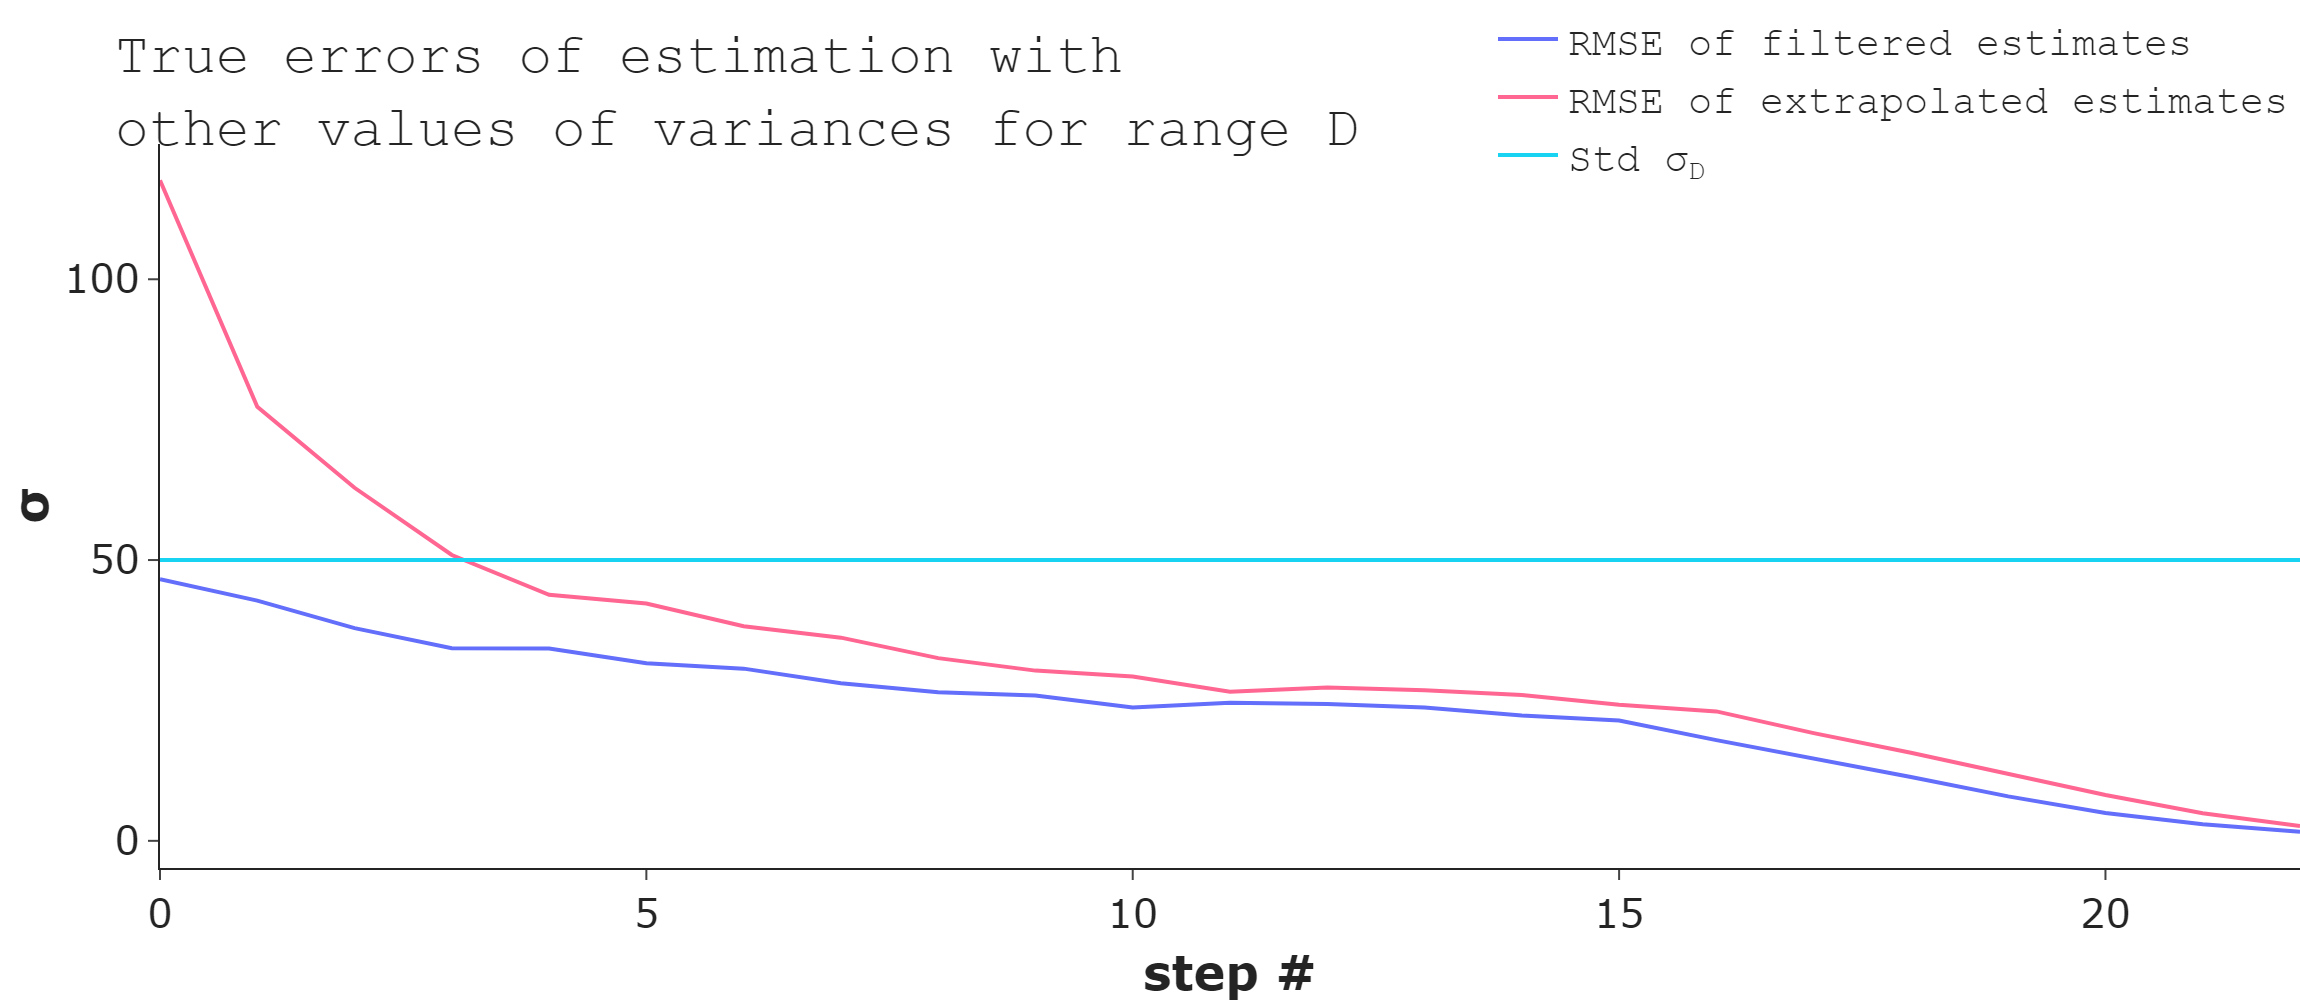

In [161]:
fig.write_image(f"True errors of estimation with other values of variances.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"True errors of estimation with other values of variances.png")

In [162]:
fig = go.Figure()

sample_size = 26
x = np.arange(sample_size)
y_RMSE_true_filtered = RMSE_true_filtered_p_diff_var[1, 3:]
y_RMSE_true_extrapol = RMSE_true_extrapol_p_diff_var[1, 3:]
y_sigma_beta = np.ones(sample_size-3) * 0.0015

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_filtered, name = 'RMSE of filtered estimates', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_RMSE_true_extrapol, name = 'RMSE of extrapolated estimates', 
                         line_color = colors[6]))

fig.add_trace(go.Scatter(x = x, y = y_sigma_beta, name = 'Std \u03c3<sub>\u03B2</sub>', 
                         line_color = colors[5]))

fig.update_layout(template = 'simple_white', 
                  title = 'True errors of estimation with<br>other values of variances for azimuth \u03B2',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "<b>\u03c3</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  #xaxis_range = [0,sample_size+1],
                  width = 1150, height = 500)
fig.show()

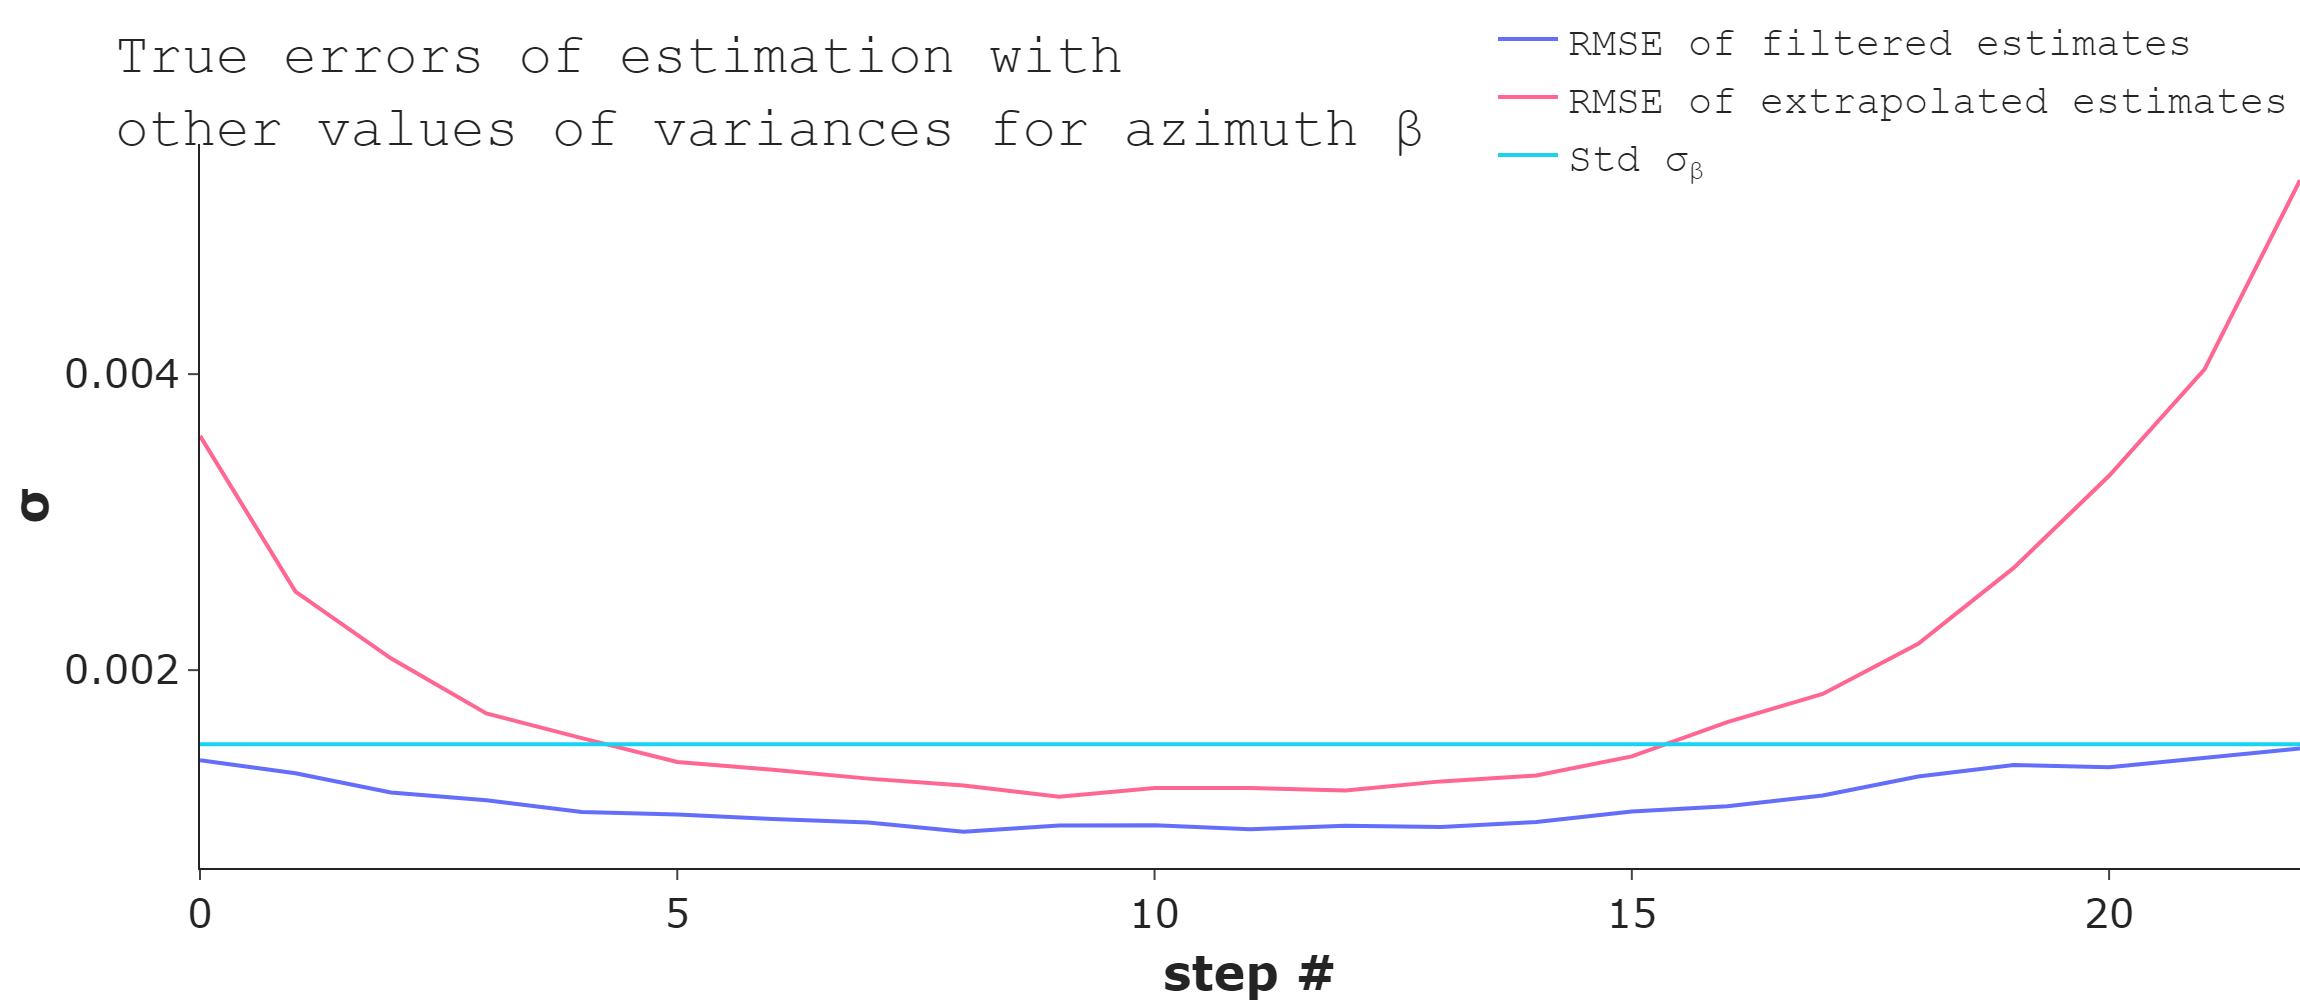

In [163]:
fig.write_image(f"True errors of estimation with other values of variances.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"True errors of estimation with other values of variances.png")

We don't observe any significant differences, so our previous conclusions hold

### Figure 12. Dependence of coordinate x on azimuth $\beta$ with a motion at close distance from an observer and other values of variances $\sigma_{D}$ = 50 and $\sigma_{\beta}$ = 0.0015

In [165]:
fig = go.Figure()

sample_size = 26
beta = X_vector_p_diff_var[1, 1:sample_size]
D = X_vector_p_diff_var[0, 1:sample_size]
x = D * np.sin(beta)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = beta, y = x, name = '', mode = 'markers',
                         marker_color = colors[0]))

fig.update_layout(template = 'simple_white', 
                  title = 'Dependence of coordinate on azimuth <br> with other values',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>azimuth \u03B2</b>',
                  yaxis_title = "<b>Object's X position</b>",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  width = 1150, height = 500)
fig.show()

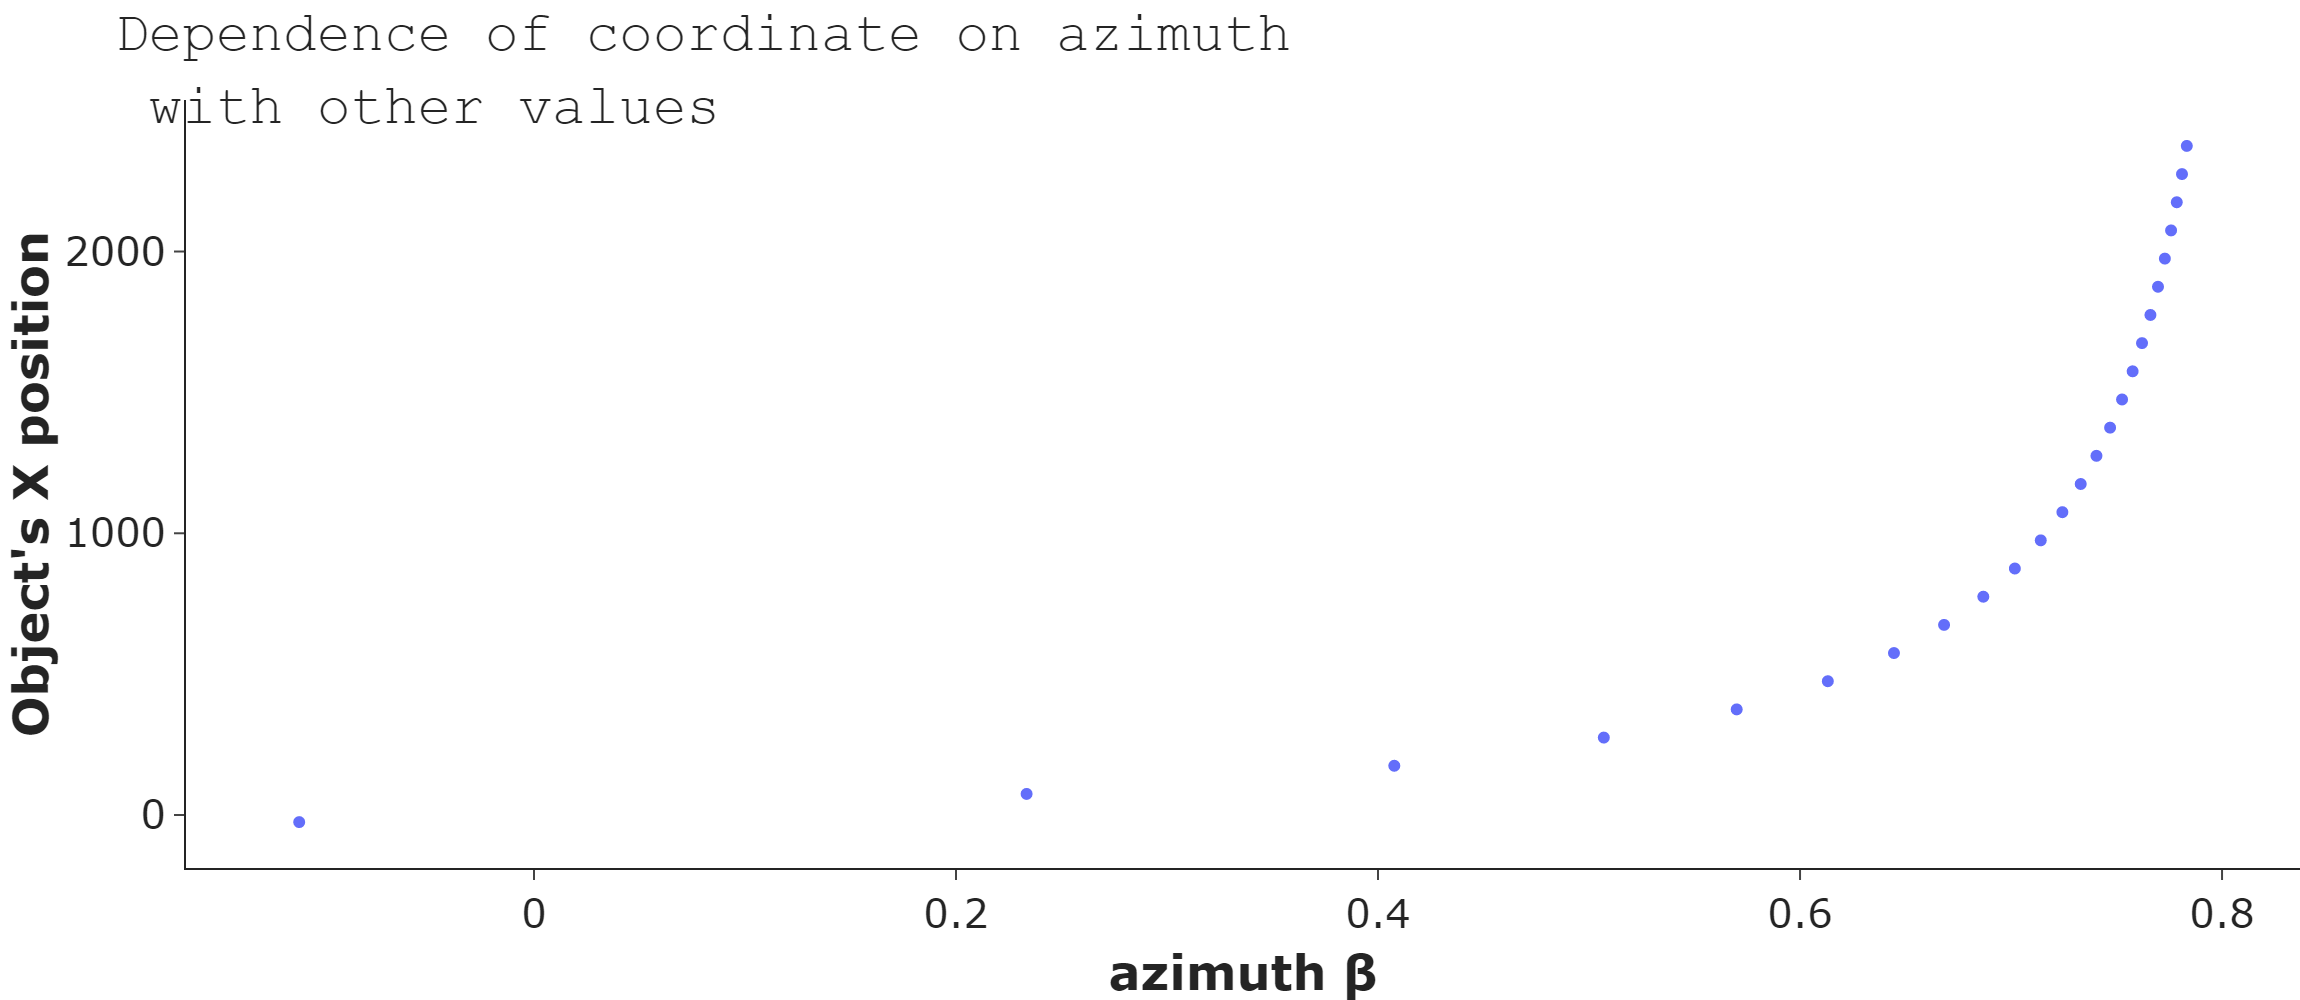

In [166]:
fig.write_image(f"Dependence of coordinate on azimuth with other values.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"Dependence of coordinate on azimuth with other values.png")

$X(\beta)$ dependence is the same as in Figure 9, that is non-linear.

### Figure 12. Condition number of covariance matrix R with a motion at close distance from an observer and other values of variances $\sigma_{D}$ = 50 and $\sigma_{\beta}$ = 0.0015

In [167]:
fig = go.Figure()

sample_size = 26
x = np.arange(sample_size)
y_con_num = condition_number(R=R_cov_diff_var)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_con_num, name = 'Condition number', 
                         line_color = colors[0]))

fig.update_layout(template = 'simple_white', 
                  title = 'Condition number of covariance matrix R <br>  with other values of variances',
                  title_font_family = 'Courier',
                  font_size = 20,
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>step #</b>',
                  yaxis_title = "",
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_font_family = 'Courier',
                  legend_orientation = 'v',
                  legend_xanchor = 'right',
                  legend_bgcolor = 'rgba(256,256,256,0)',
                  legend_x = 1,
                  legend_y = 1.2,
                  width = 1150, height = 500)
fig.show()

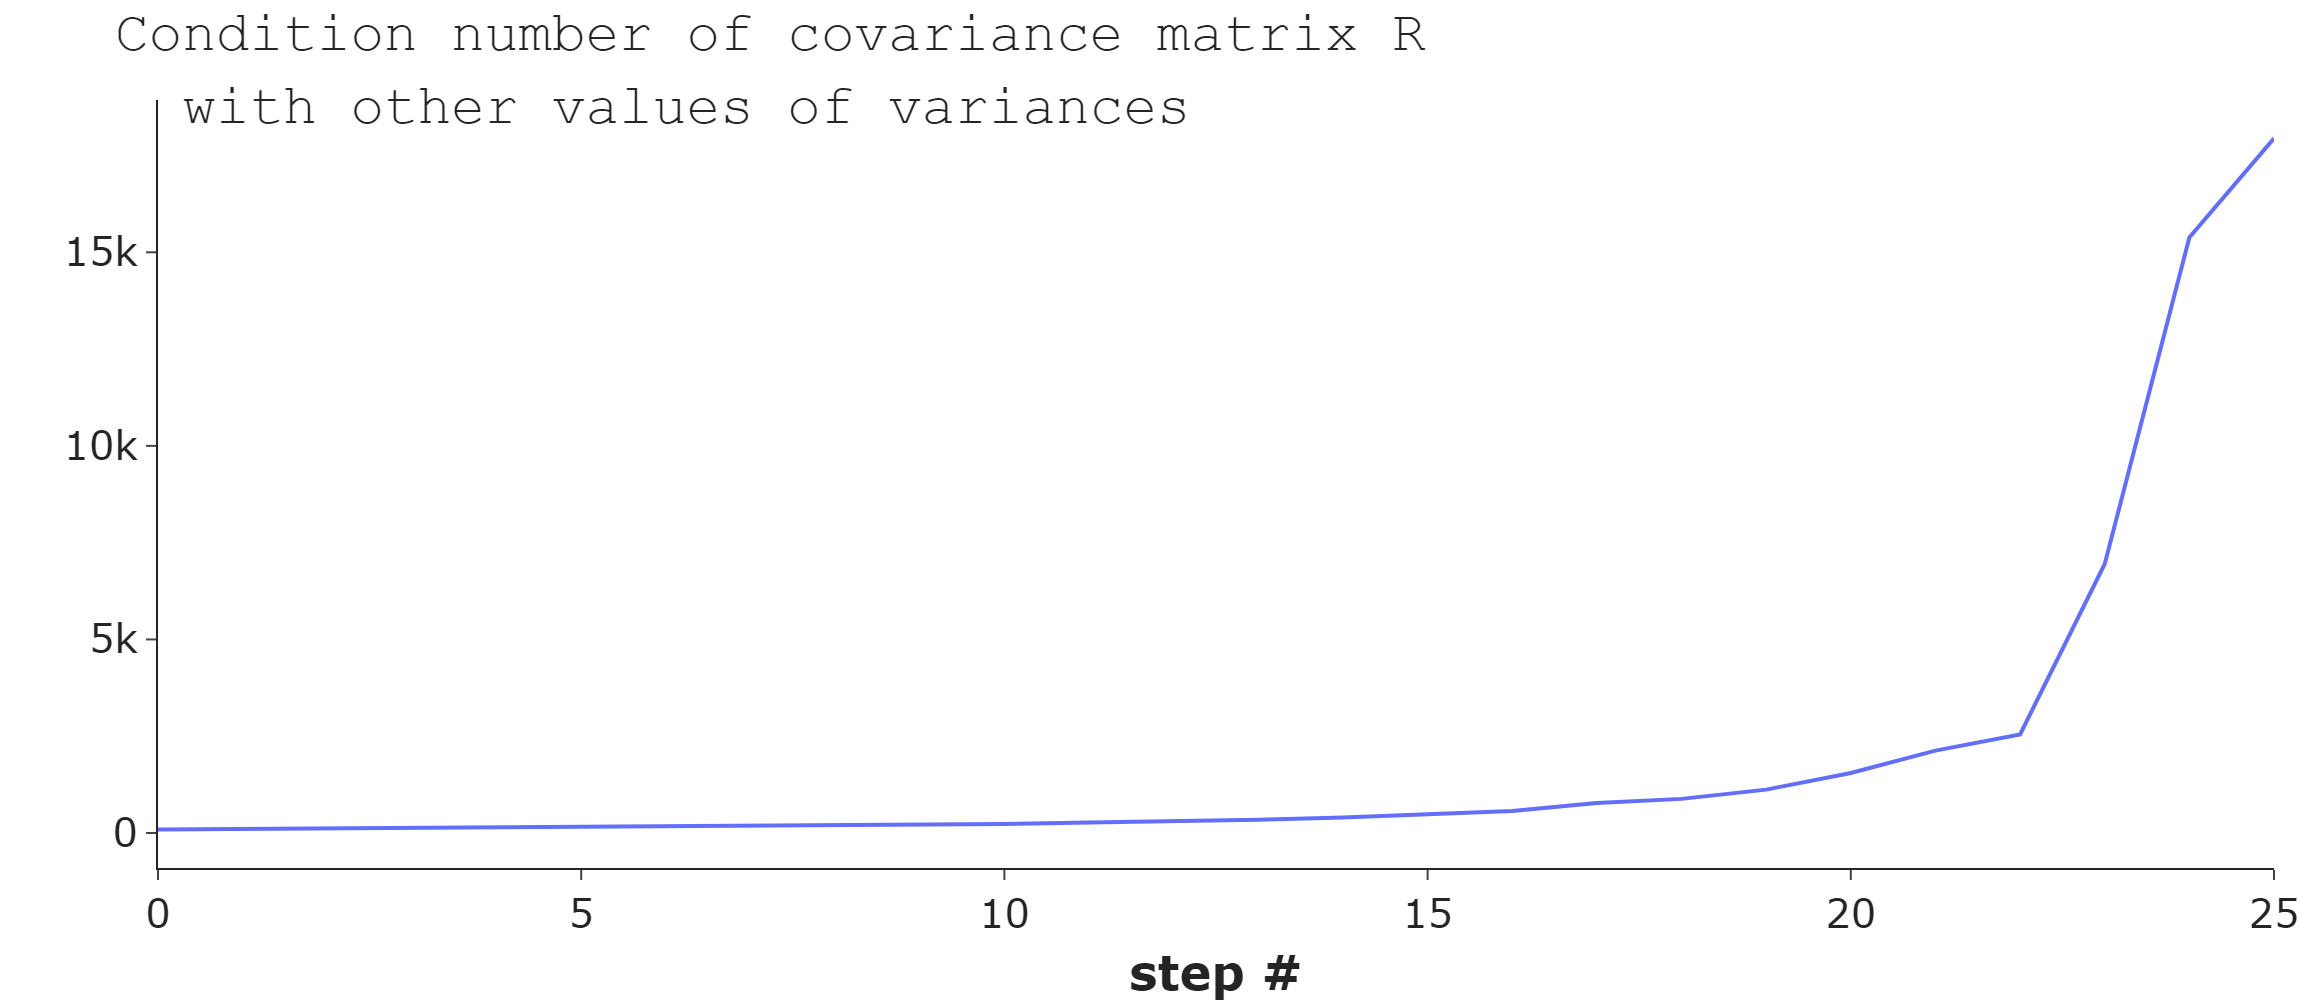

In [168]:
fig.write_image(f"Dependence of coordinate on azimuth with other values.png", 
                format = 'png', width = 1150, height = 500, scale = 2)
Image(f"Dependence of coordinate on azimuth with other values.png")

Condition number dynamics illustrates that this is even more ill-conditioned problem than the previous one: we no longer observe close to 1 values at any step and condition number quickly exceeds 1000.

## Conclusion

Navigation system may diverge 
1. Due to low sample size (condition number is too high)
2. Due to proximity of object to observer
3. Due to disproportion between variances of distance and azimuth

<br>So this is a feature importance analysis of kalman filter.

When the object motion at a close distance from an observer and the high condition number yields to ill-condition problem, navigation system may become blind and filter may diverge. Ill-condition problem has the greater influence than linearization problem as the linearization errors can be solved by increasing the number of points in the sample. To overcome the ill-conditioned problem, there is need to use Extended Kalman Filtering. In other words, we do not need to traslate nonlinear system to linear one and try to solve it. Instead of this, we need to handle with nonlinear system itself to overcome above mentioned problems.